# Analysis of NSF awards to WHOI
Created by Ivan Lima on Tue Aug 18 2020 21:05:03 -0400

WHOI is the top organization in terms of number of awards (13.9% of total) and the second largest in terms of total amount awarded (16.3% of total). In this notebook we examine gender differences in the NSF awards that went to WHOI. The metrics we use for gender discrepancies are the annual fraction of female PIs and co-PIs in the awards. We track those metrics across: 

1. All WHOI NSF-OCE awards.
2. Awards from the top 10 largest NSF programs (in number of awards).
3. Identified research topics.
4. Award types

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tnrange, notebook
import warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Tue Jul 27 14:01:43 2021


In [2]:
warnings.filterwarnings('ignore')
sns.set_theme(context='paper', style='whitegrid', palette='tab10', rc={'figure.dpi':100})
pd.options.display.max_columns = 50

Read NSF award data.

In [3]:
data_types = {'Abstract':'string', 'Title':'string', 'Programs':'string', 'PI':'string',
              'Organization':'string', 'State':'string', 'Instrument':'string', 'co-PIs':'string',
              'program':'string', 'PI_first_name':'string', 'co-PI_first_name':'string',
              'PI_gender':'string', 'co-PI_gender':'string'}
awards = pd.read_csv('results/awards_1985-2020_clean_edited_grouped_gender_topic.csv', index_col=0,
                     parse_dates=[4,5], dtype=data_types)
awards['year'] = awards.StartDate.dt.year
awards.loc[awards.program=='DATA NOT AVAILABLE','program'] = np.nan
awards['co-PI_female_pct'] = awards['co-PI_female_frac'] * 100

periods = np.array([[y,]*3 for y in range(1989,2021,3)]).flatten() # 3-year periods
years = np.arange(1987,2020)
year_to_period = {y:p for y,p in zip(years,periods)}
awards['period'] = awards.year.map(year_to_period) # map year to period

topic_probs = pd.read_csv('results/topic_probs.csv', index_col=0)
topic_words = pd.read_csv('results/topic_words.csv', index_col=0)

npzfile = np.load('results/NMF_TSNE.npz')
feature_names  = npzfile['feature_names']
nmf_components = npzfile['nmf_components']
topic_names    = npzfile['topic_names']
topic_names_r  = npzfile['topic_names_r']
X_tsne         = npzfile['X_tsne']
npzfile.close()

df_ref = pd.read_csv('results/gender_ref.csv',index_col=0)
whoi_awards = awards[awards.Organization == 'Woods Hole Oceanographic Institution'] # WHOI awards

# Read geosciences/atmospheric/ocean sciences academic gender workforce data
workforce = pd.read_csv('data/nsf_workforce.csv')#, index_col=0)
workforce['female_frac'] = workforce.female/workforce.total
workforce['female_pct'] = workforce['female_frac'] * 100
workforce = workforce.set_index('year')

The figure below shows the number of awards and the amount awarded by NSF Ocean Sciences to WHOI per year, and a box plot of the amount awarded to individual projects in each year between 1987 and 2019.

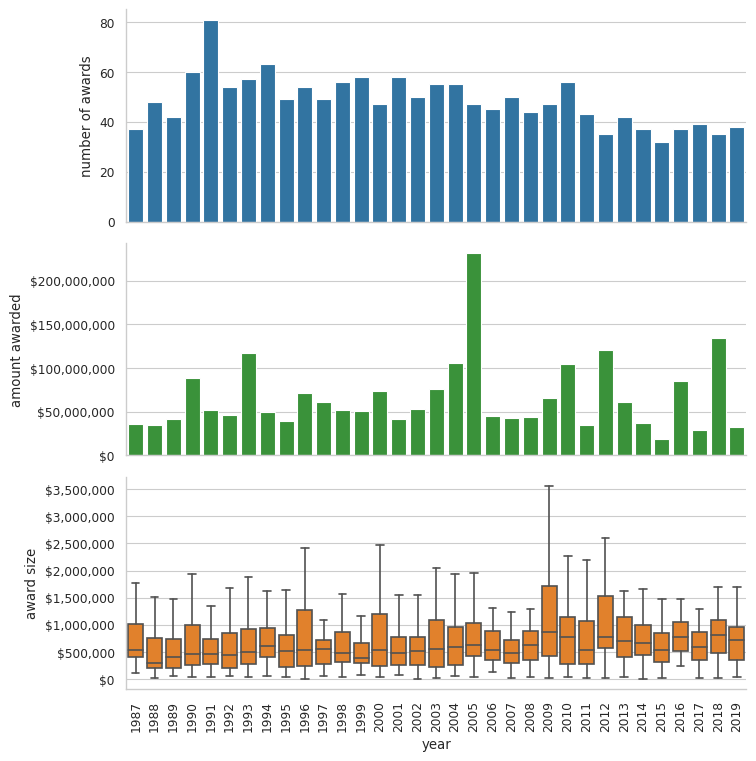

In [4]:
from matplotlib import ticker
def dollar(x, pos):
    return '${:,.0f}'.format(x)

fmt = ticker.FuncFormatter(dollar)
df_per_year = pd.DataFrame({'number':whoi_awards.groupby('year')['Abstract'].count(),
                            'amount':whoi_awards.groupby(['year'])['tot_amount_adjusted'].sum()})

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(8,9))
fig.subplots_adjust(hspace=0.1)
_ = sns.barplot(data=df_per_year, x=df_per_year.index, y='number', color='C0', ax=axs[0])
_ = sns.barplot(data=df_per_year, x=df_per_year.index, y='amount', color='C2', ax=axs[1])
_ = sns.boxplot(data=whoi_awards, x='year', y='tot_amount_adjusted', color='C1', showfliers=False, ax=axs[2])
_ = axs[2].set_xticklabels(df_per_year.index, rotation=90)
_ = axs[0].set(ylabel='number of awards')
_ = axs[1].set(ylabel='amount awarded')
_ = axs[2].set(ylabel='award size')
for n in range(1,3):
    _ = axs[n].yaxis.set_major_formatter(fmt)

for n in range(0,2):
    _ = axs[n].set(xlabel='')

sns.despine(fig)

### Award size by gender

Statistics of the individual awards received by male and female PIs.

In [5]:
awards_male = whoi_awards[whoi_awards.PI_gender == 'male'][['year','tot_amount_adjusted']]
awards_female = whoi_awards[whoi_awards.PI_gender == 'female'][['year','tot_amount_adjusted']]

stats = pd.DataFrame({'male PIs': awards_male.tot_amount_adjusted.describe(),
                      'female PIs':awards_female.tot_amount_adjusted.describe()})
stats

,male PIs,female PIs
count,1.315000e+03,2.850000e+02
mean,1.491952e+06,7.417788e+05
std,5.018485e+06,8.161119e+05
min,1.629426e+00,2.077213e+04
25%,2.873201e+05,2.986645e+05
50%,5.489567e+05,5.576218e+05
75%,9.617617e+05,8.650872e+05
max,7.018893e+07,8.187267e+06


Box plot of the amount awarded (award size) to individual projects by male and female PIs. The green triangles represent the mean award size. The t-test for equal means shows that thedifference between the mean award size for male and female PIs is statistically significant.

T-test for equal means: t=2.516, p=0.012, df=1598


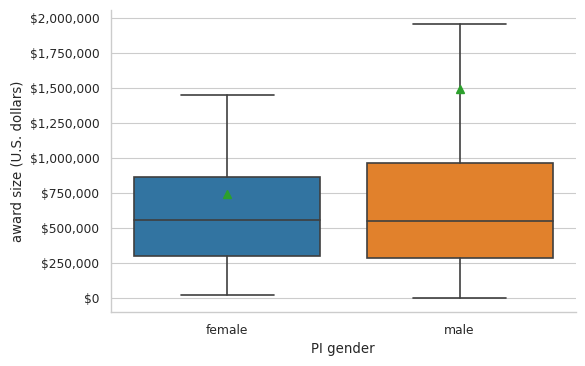

In [6]:
fig, ax = plt.subplots()
_ = sns.boxplot(data=whoi_awards, x='PI_gender', y='tot_amount_adjusted', showfliers=False, showmeans=True, ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set(xlabel='PI gender', ylabel='award size (U.S. dollars)')

male = awards_male.tot_amount_adjusted.values
female = awards_female.tot_amount_adjusted.values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}'.format(tstat, pval, df))
sns.despine(fig)

Probability density plot of award size by PI gender. The distribution for male and female PIs is virtually identical.

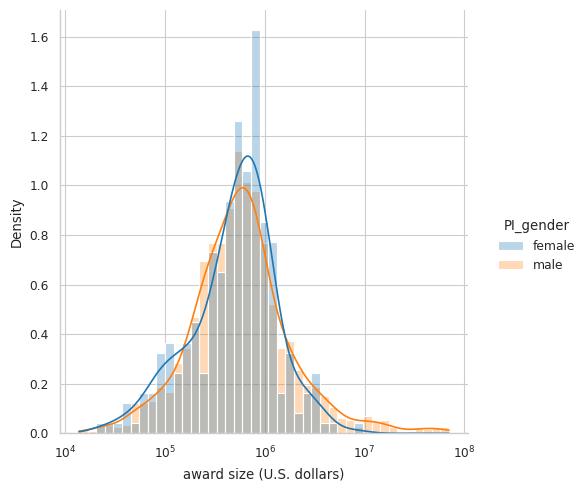

In [7]:
df = whoi_awards[whoi_awards.tot_amount_adjusted>1000]
g = sns.displot(df, x='tot_amount_adjusted', log_scale=True, hue='PI_gender', stat='density', common_norm=False, alpha=0.3, kde=True)#, element='step')
_ = g.set_xlabels('award size (U.S. dollars)')

Box plot of the amount awarded to individual projects by male and female PIs in each year.

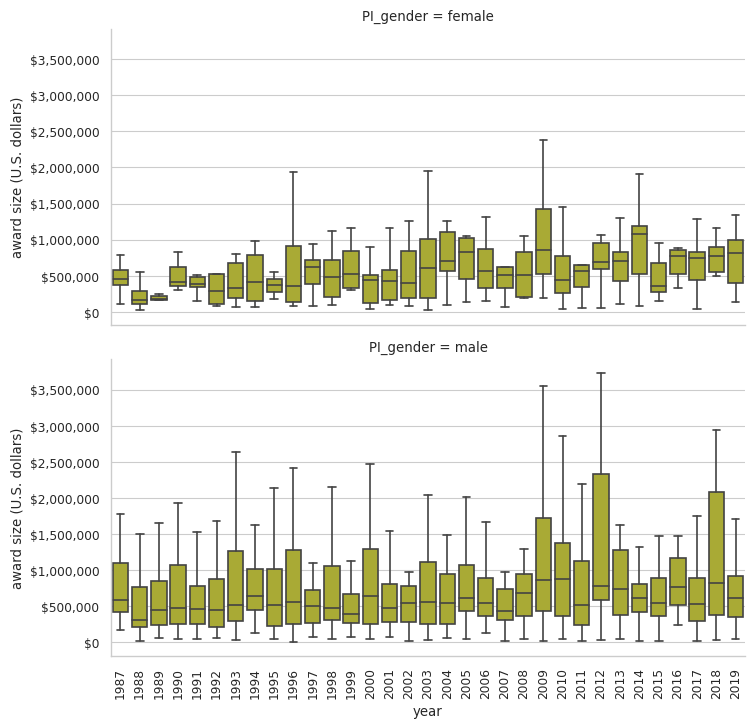

In [8]:
g = sns.catplot(data=whoi_awards, x='year', y='tot_amount_adjusted', row='PI_gender', kind='box', showfliers=False, height=3.5, aspect=2, color='C8')
_ = g.set_xticklabels(rotation=90)
_ = g.set_ylabels('award size (U.S. dollars)')
for ax in g.axes:
    ax[0].yaxis.set_major_formatter(fmt)

Time series of median award size to male and female PIs.

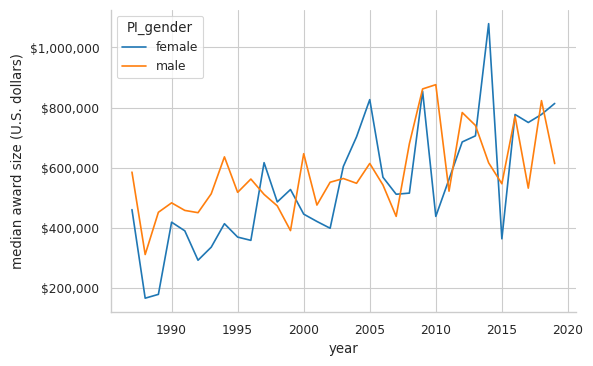

In [9]:
fig, ax = plt.subplots()
_ = sns.lineplot(data=whoi_awards, x='year', y='tot_amount_adjusted', hue='PI_gender', estimator=np.median, ci=None, ax=ax)
_ = ax.set(ylabel='median award size (U.S. dollars)')
_ = ax.yaxis.set_major_formatter(fmt)
sns.despine(fig)

### Female fraction of co-PIs by PI gender

KDE plot of the percentage of female co-PIs by PI gender and t-test for equal means. Awards with female PIs have a higher percentage of female co-PIs but the difference between the means is not statistically significant.

T-test for equal means: t=-1.831, p=0.067, df=871



,mean,number of awards
PI_gender,,
female,25.41%,183
male,19.89%,690


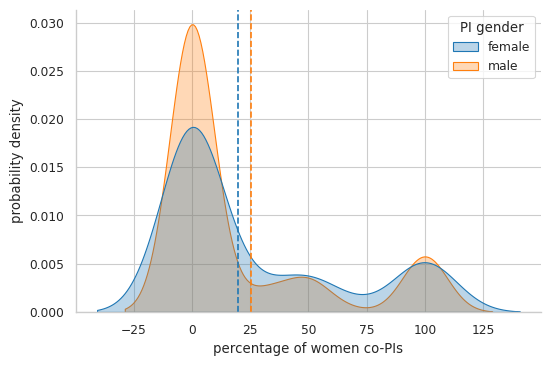

In [10]:
means_female_pct = whoi_awards.groupby('PI_gender')['co-PI_female_pct'].mean()
fig, ax = plt.subplots()
_ = sns.kdeplot(data=whoi_awards, x='co-PI_female_pct', hue='PI_gender', common_norm=False, alpha=0.3, fill=True, ax=ax)
_ = ax.legend_.set_title('PI gender')
_ = ax.set(xlabel='percentage of women co-PIs', ylabel='probability density')
_ = ax.axvline(means_female_pct['male'], c='C0', ls='--')
_ = ax.axvline(means_female_pct['female'], c='C1', ls='--')
sns.despine(fig)

awards_with_copis = whoi_awards[awards['num_co-PIs'].notnull()]
df_male = awards_with_copis[awards_with_copis.PI_gender=='male']
df_female = awards_with_copis[awards_with_copis.PI_gender=='female']
male = df_male['co-PI_female_pct'].dropna().values
female = df_female['co-PI_female_pct'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}\n'.format(tstat, pval, df))

s1 = awards_with_copis.groupby(['PI_gender'])['co-PI_female_pct'].mean()
s2 = awards_with_copis.groupby(['PI_gender'])['co-PI_female_pct'].count()
df = pd.concat([s1,s2], axis=1, keys=['mean', 'number of awards'])
df.style.format('{0:,.2f}%', subset='mean')

### Number of co-PIs by PI gender

KDE plot of the number of co-PIs by PI gender and t-test for equal means.

T-test for equal means: t=-0.196, p=0.845, df=871



,mean,number of awards
PI_gender,,
female,1.737705,183
male,1.715942,690


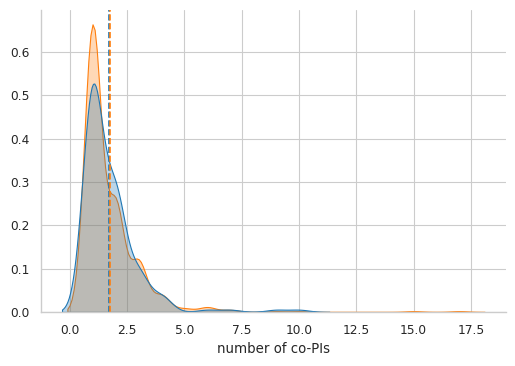

In [11]:
means_num_copi = whoi_awards.groupby('PI_gender')['num_co-PIs'].mean()
fig, ax = plt.subplots()
_ = sns.kdeplot(data=whoi_awards, x='num_co-PIs', hue='PI_gender', common_norm=False, alpha=0.3, fill=True, legend=False, ax=ax)
_ = ax.set(xlabel='number of co-PIs', ylabel='')
_ = ax.axvline(means_num_copi['male'], c='C0', ls='--')
_ = ax.axvline(means_num_copi['female'], c='C1', ls='--')
sns.despine(fig)

df_male = awards_with_copis[awards_with_copis.PI_gender=='male']
df_female = awards_with_copis[awards_with_copis.PI_gender=='female']
male = df_male['num_co-PIs'].dropna().values
female = df_female['num_co-PIs'].dropna().values
tstat, pval, df = sm.stats.ttest_ind(male, female)
print('T-test for equal means: t={:.3f}, p={:.3f}, df={:.0f}\n'.format(tstat, pval, df))

s1 = awards_with_copis.groupby(['PI_gender'])['num_co-PIs'].mean()
s2 = awards_with_copis.groupby(['PI_gender'])['num_co-PIs'].count()
df = pd.concat([s1,s2], axis=1, keys=['mean', 'number of awards'])
df

The figure below shows a time series of the annual mean number of co-PIs by PI gender. The shaded area represents the 95% confidence interval of the annual means.

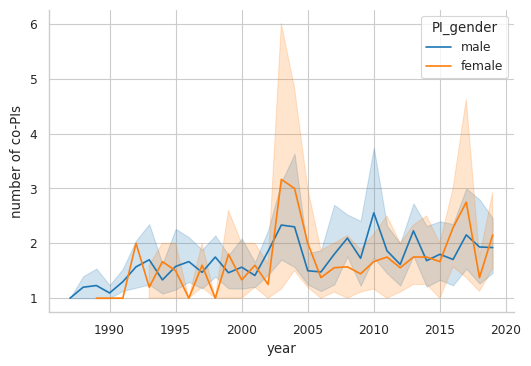

In [12]:
fig, ax = plt.subplots()
_ = sns.lineplot(data=whoi_awards, x='year', y='num_co-PIs', hue='PI_gender', hue_order=['male','female'], ax=ax)
_ = ax.set(ylabel='number of co-PIs')
sns.despine(fig)

Box plot of interdisciplinarity by number of co-PIs

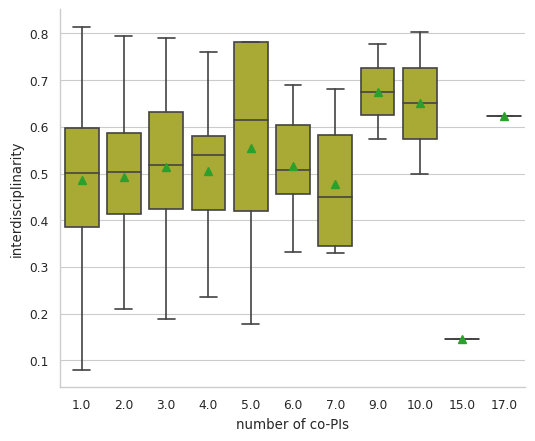

In [13]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.boxplot(data=whoi_awards, x='num_co-PIs', y='evenness', showfliers=False, showmeans=True, color='C8', ax=ax)
_ = ax.set(ylabel='interdisciplinarity', xlabel='number of co-PIs')
sns.despine(fig)

Line plot of interdisciplinarity by number of co-PIs and PI gender

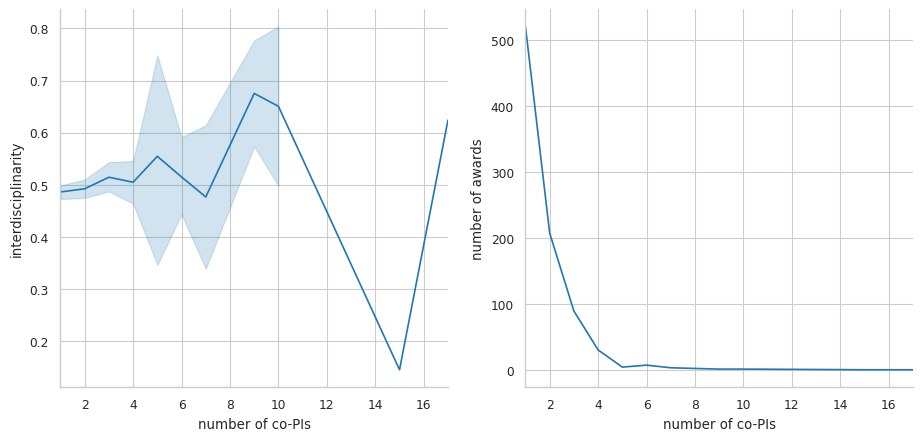

In [14]:
df = whoi_awards['num_co-PIs'].value_counts()
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(11,5))
_ = sns.lineplot(data=whoi_awards, x='num_co-PIs', y='evenness', ax=axs[0])
_ = axs[0].set(ylabel='interdisciplinarity', xlabel='number of co-PIs')
_ = axs[0].autoscale(axis='x', tight=True)
_ = sns.lineplot(x=df.index, y=df.values, ax=axs[1])
_ = axs[1].set(ylabel='number of awards', xlabel='number of co-PIs')
sns.despine(fig)

### Temporal trends in gender composition

The figure below shows the time series of the annual percentage of female PIs and co-PIs across all WHOI awards and the percentage of females in the academic workforce. The shaded area represents the 95% confidence interval.

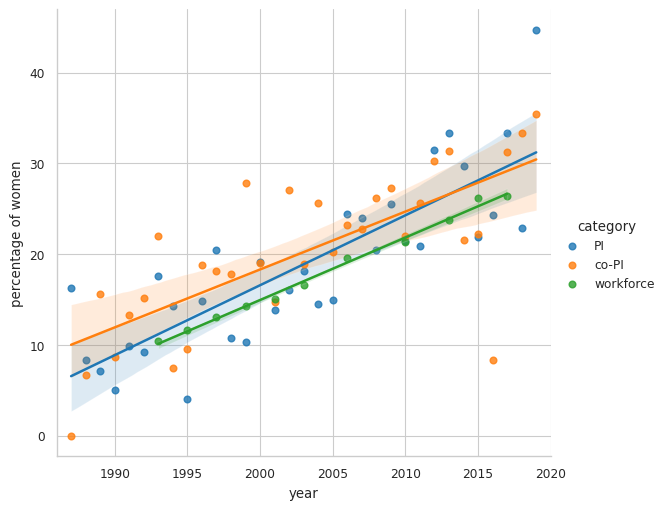

In [15]:
# female & male fraction of PIs
pi_gender = whoi_awards.groupby(['year','PI_gender'])['Abstract'].count().unstack()
pi_gender = pi_gender.divide(pi_gender.sum(axis=1), axis=0) * 100 # fraction -> percentage

# female & male fraction of co-PIs
copi_gender = pd.DataFrame({'female':whoi_awards.groupby('year')['co-PI_female_frac'].mean()})
copi_gender = copi_gender * 100 # fraction -> percentage

# combine PI, co-PI and workforce data into one dataframe
df_all = pd.concat([pi_gender.female.rename('PI'), copi_gender.female.rename('co-PI'),
                    workforce.female_pct.rename('workforce')], axis=1).stack()
df_all = df_all.reset_index().rename(columns={'level_1':'category',0:'percentage'})

g = sns.lmplot(data=df_all, x='year', y='percentage', hue='category', aspect=1.1)
_ = g.set(ylabel='percentage of women', xlim=(1986,2020))

In [16]:
def linreg(x, y):
    X = sm.add_constant(x)
    lreg = sm.OLS(y,X).fit()
    return lreg, X

params = []
female_pct = pd.DataFrame({'PI':pi_gender['female'], 'co-PI':copi_gender['female']})
for x, y, in zip([female_pct.index, female_pct.index, workforce.index],
                 [female_pct.PI, female_pct['co-PI'], workforce.female_pct]):
    reg, X = linreg(x, y)
    params.append([reg.rsquared,reg.params[1],reg.params[0],reg.pvalues[1]])
#     p, slope, rsquared = reg.pvalues[1], reg.params[1], reg.rsquared
lr_stats = pd.DataFrame(np.array(params), index=['PI','co-PI','workforce'],
                        columns=['R^2','slope','intercept','p-value'])
lr_stats.style.format('{:.3f}', subset=['R^2','slope','intercept'])

,R^2,slope,intercept,p-value
PI,0.677,0.770,-1524.335,0.000000
co-PI,0.527,0.638,-1257.848,0.000002
workforce,0.994,0.688,-1362.060,0.000000


Linear trends fit the data reasonably well.

We use a multivariate linear regression of *female fraction* on *time* (year), *category* (PI or co-PI) plus an interaction term (*time* $\times$ *category*) to test whether the temporal trend (slope) and the mean female fraction (intercept) are different between PIs and co-PIs. The table below shows the results from the multivariate linear regression. The large $p$ values for *category* and the interaction term indicate that the differences in intercept and regression slope between PIs and co-PIs are not statistically significant.

In [17]:
import statsmodels.formula.api as smf

df_pi = pd.DataFrame({'fem_frac':female_pct['PI'], 'category':'PI'})
df_copi = pd.DataFrame({'fem_frac':female_pct['co-PI'], 'category':'co-PI'})
df = pd.concat([df_pi,df_copi]).reset_index()
df = df.rename(columns={'StartDate':'year'})
lreg = smf.ols(formula='fem_frac ~ year + category + year:category', data=df)
res = lreg.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               fem_frac   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     32.22
Date:                Tue, 27 Jul 2021   Prob (F-statistic):           1.12e-12
Time:                        14:01:53   Log-Likelihood:                -205.21
No. Observations:                  66   AIC:                             418.4
Df Residuals:                      62   BIC:                             427.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -1524.3350    204.826     -7.442      0.000   -1933.776   -1114.894
category[T.co-PI]        266.4874    289.668      0.920      0.361    -312.550     845.525
year                       0.7705      0.102      7.534      0.000       0.566       0.975
year:category[T.co-PI]    -0.1324      0.145     -0.915      0.364      -0.421       0.157
==============================================================================
Omnibus:                        8.447   Durbin-Watson:                   2.111
Prob(Omnibus):                  0.015   Jarque-Bera (JB):               10.482
Skew:                          -0.507   Prob(JB):                      0.00530
Kurtosis:                       4.668   Cond. No.                     1.10e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## NSF programs

### Top 10 programs in number of awards at WHOI

The table and histogram below show the top 10 NSF-OCE programs at WHOI in number of awards for the period 1987-2019.

,number of awards,percentage of total,cum percentage of total
MARINE GEOLOGY AND GEOPHYSICS,398,24.88,24.88
PHYSICAL OCEANOGRAPHY,353,22.06,46.94
CHEMICAL OCEANOGRAPHY,223,13.94,60.88
BIOLOGICAL OCEANOGRAPHY,212,13.25,74.12
OCEAN TECH & INTERDISC COORDIN,100,6.25,80.38
OCEANOGRAPHIC INSTRUMENTATION,47,2.94,83.31
SHIPBOARD SCIENTIFIC SUPP EQUI,37,2.31,85.62
OCEAN DRILLING PROGRAM,32,2.00,87.62
MAJOR RESEARCH INSTRUMENTATION,21,1.31,88.94
SUBMERSIBLE SUPPORT,14,0.88,89.81


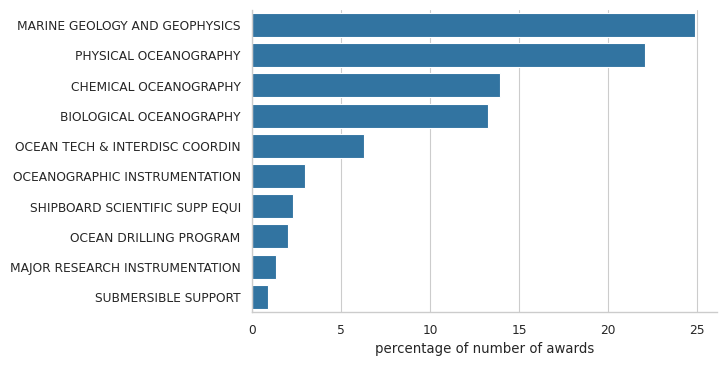

In [18]:
top10_programs = pd.DataFrame({'number of awards': whoi_awards.program.value_counts()[:10]})
top10_programs['percentage of total'] = top10_programs['number of awards'] / len(whoi_awards) * 100
top10_programs['cum percentage of total'] = top10_programs['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = sns.barplot(data=top10_programs, y=top10_programs.index, x='percentage of total', orient='h', color='C0', ax=ax)
_ = ax.set(xlabel='percentage of number of awards')
sns.despine(fig)

top10_programs.style.format('{:.2f}', subset=['percentage of total','cum percentage of total'])

The table and histogram below show the total amount awarded (budget) for the top 10 NSF-OCE programs at WHOI in number of awards for the period 1987-2019.

,amount awarded,percentage of total,cum percentage of total
program,,,
PHYSICAL OCEANOGRAPHY,"$488,980,300.89",22.499196,22.499196
MARINE GEOLOGY AND GEOPHYSICS,"$349,974,695.94",16.103204,38.602400
BIOLOGICAL OCEANOGRAPHY,"$299,215,442.45",13.767645,52.370045
CHEMICAL OCEANOGRAPHY,"$155,031,388.07",7.133379,59.503423
SUBMERSIBLE SUPPORT,"$110,985,969.24",5.106740,64.610163
OCEAN TECH & INTERDISC COORDIN,"$88,326,099.24",4.064103,68.674266
OCEANOGRAPHIC INSTRUMENTATION,"$36,938,205.74",1.699618,70.373884
SHIPBOARD SCIENTIFIC SUPP EQUI,"$33,460,757.92",1.539612,71.913497
MAJOR RESEARCH INSTRUMENTATION,"$21,400,334.22",0.984682,72.898179


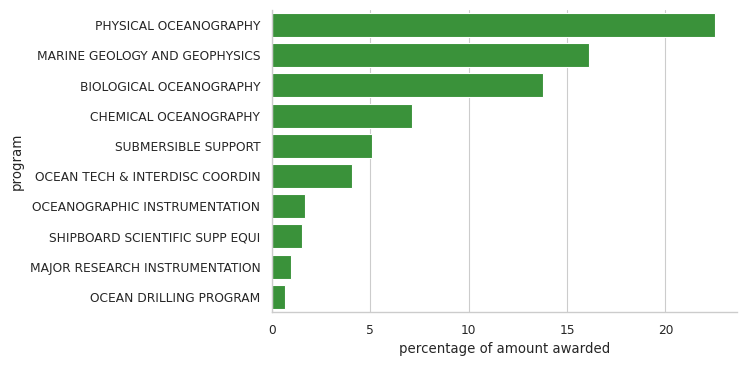

In [19]:
awards_top10 = whoi_awards[whoi_awards.program.isin(top10_programs.index)]
top10_programs_amount = pd.DataFrame({'amount awarded': awards_top10.groupby('program')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
top10_programs_amount['percentage of total'] = top10_programs_amount['amount awarded'] / whoi_awards['tot_amount_adjusted'].sum() * 100
top10_programs_amount['cum percentage of total'] = top10_programs_amount['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = sns.barplot(data=top10_programs_amount, y=top10_programs_amount.index, x='percentage of total', orient='h', color='C2', ax=ax)
_ = ax.set(xlabel='percentage of amount awarded')
sns.despine(fig)

top10_programs_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by program.

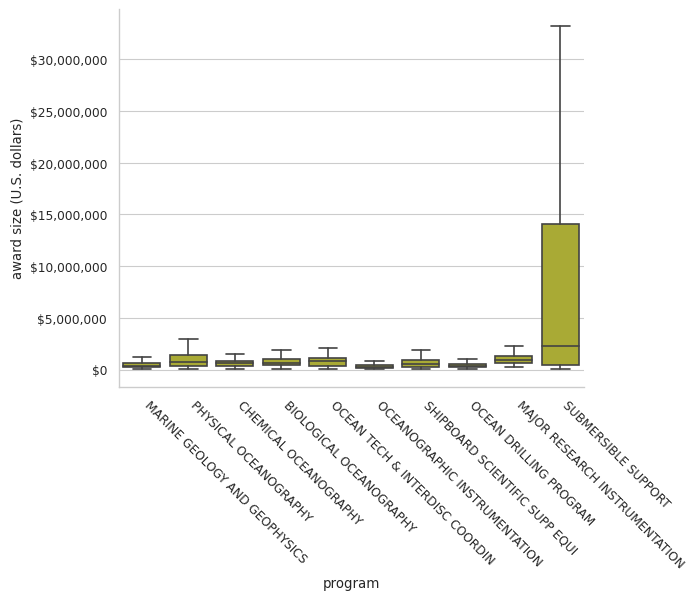

In [20]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.boxplot(data=awards_top10, x='program', y='tot_amount_adjusted', showfliers=False,
                order=top10_programs.index, color='C8', ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
sns.despine(fig)

Boxplot of award size by program and PI gender.

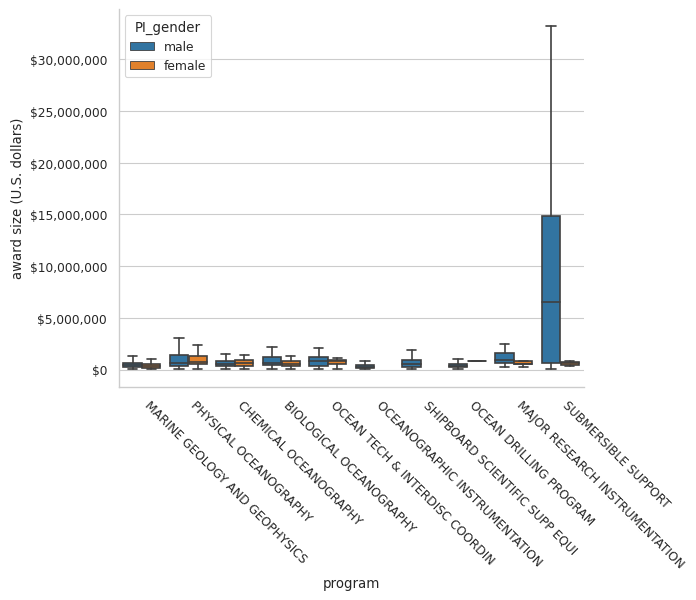

In [21]:
# df = awards_top10[awards_top10.program != 'SUBMERSIBLE SUPPORT']
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.boxplot(data=awards_top10, x='program', y='tot_amount_adjusted', showfliers=False,
                order=top10_programs.index, hue='PI_gender', hue_order=['male','female'], ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
sns.despine(fig)

The figure below shows the time series of the number of awards and the percentage of awards per year for each of the top 10 programs at WHOI.

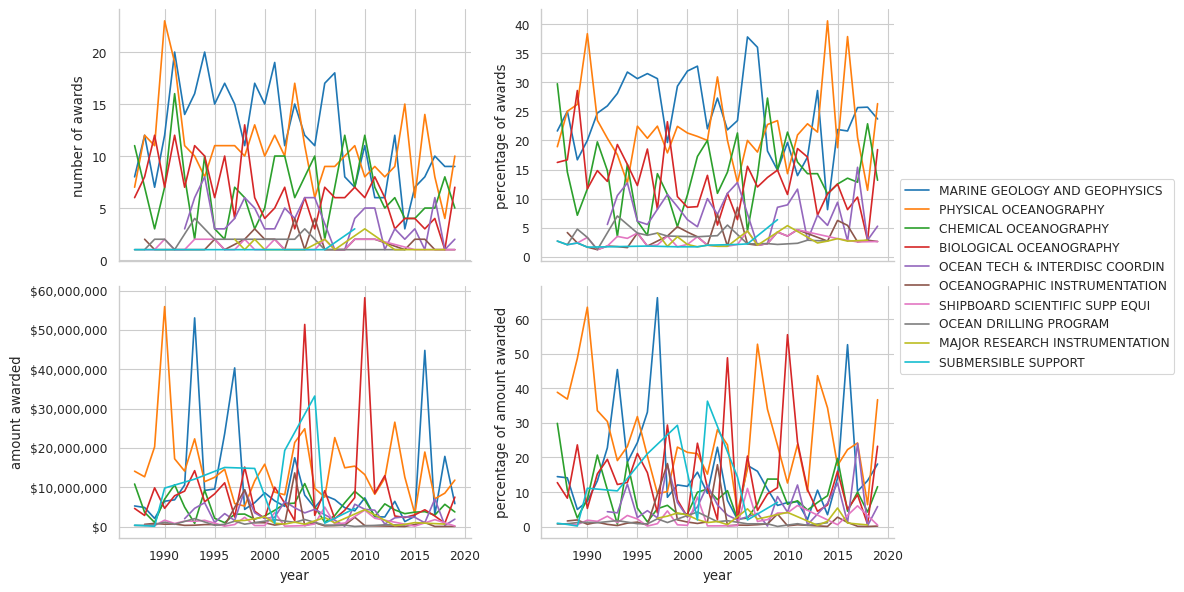

In [22]:
num_awards_per_year = whoi_awards.groupby(['year'])['Abstract'].count()
amount_awarded_per_year =  whoi_awards.groupby(['year'])['tot_amount_adjusted'].sum()

prog_year = pd.DataFrame({'number of awards': awards_top10.groupby(['year','program'])['Abstract'].count()})
prog_year['percentage of awards'] = prog_year['number of awards'].div(num_awards_per_year, axis=0) * 100
prog_year['amount awarded'] = awards_top10.groupby(['year','program'])['tot_amount_adjusted'].sum()
prog_year['percentage of amount awarded'] = prog_year['amount awarded'].div(amount_awarded_per_year,axis=0) * 100

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,7))
fig.subplots_adjust(hspace=0.1)
_ = sns.lineplot(data=prog_year, x='year', y='number of awards', hue='program', hue_order=top10_programs.index, ax=axs[0,0], legend=False)
_ = sns.lineplot(data=prog_year, x='year', y='percentage of awards', hue='program', hue_order=top10_programs.index, ax=axs[0,1])
_ = sns.lineplot(data=prog_year, x='year', y='amount awarded', hue='program', hue_order=top10_programs.index, ax=axs[1,0], legend=False)
_ = sns.lineplot(data=prog_year, x='year', y='percentage of amount awarded', hue='program', hue_order=top10_programs.index, ax=axs[1,1], legend=False)
_ = axs[1,0].yaxis.set_major_formatter(fmt)
_ = axs[0,1].legend(loc='upper left',bbox_to_anchor=(1, 0.35))
sns.despine(fig)

### Frequency distribution of NSF programs by PI gender at WHOI

The table and figure below show the distribution (relative proportion) of different NSF-OCE programs (top 10 in number) by PI gender. The table and figure show how the awards from each gender (PI) are distributed across the top 10 NSF-OCE programs (in number).

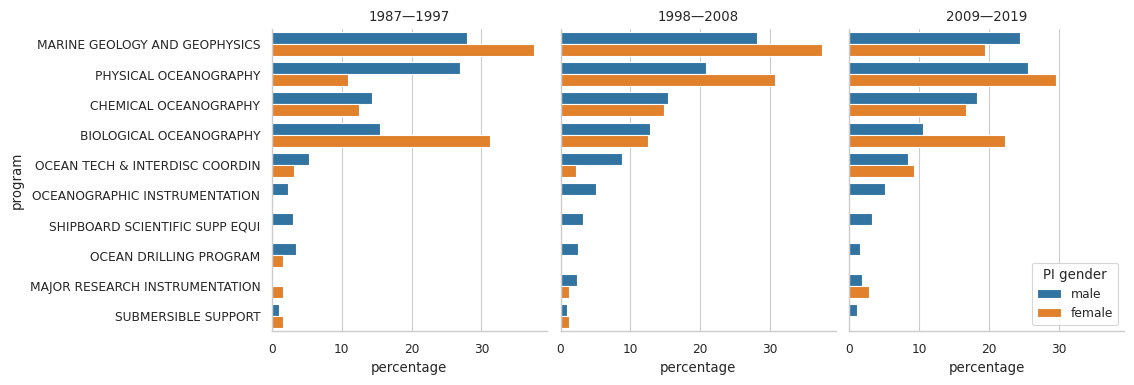

In [23]:
awards_top10_1 = awards_top10[awards_top10.year<1998]                              # 1987-1997
awards_top10_2 = awards_top10[(awards_top10.year>1997) & (awards_top10.year<2009)] # 1998-2008
awards_top10_3 = awards_top10[awards_top10.year>2008]                              # 2009-2019

titles = [u'1987\u20141997',u'1998\u20142008',u'2009\u20142019']
dflist = []

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_top10_1, awards_top10_2, awards_top10_3], titles):
    df_1 = df.groupby(['program','PI_gender'])['Abstract'].count()
    df_2 = df.groupby(['PI_gender'])['Abstract'].count()
    df_pct = (df_1.div(df_2) * 100).reindex(top10_programs.index, level='program')
    dflist.append(df_pct.unstack())
    df_pct = df_pct.rename('percentage').reset_index()
    _ = sns.barplot(data=df_pct, y='program', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], order=top10_programs.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
ax.legend(title='PI gender',loc='lower right')
sns.despine(fig)

df_top10 = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
df_top10.style.format('{:.2f}')

### Gender composition across top 10 programs (in number of awards) at WHOI

PI gender percentage in the top 10 NSF-OCE programs at WHOI. The table and figure show the PI gender composition in the top 10 NSF-OCE programs in three different 11-year time periods.

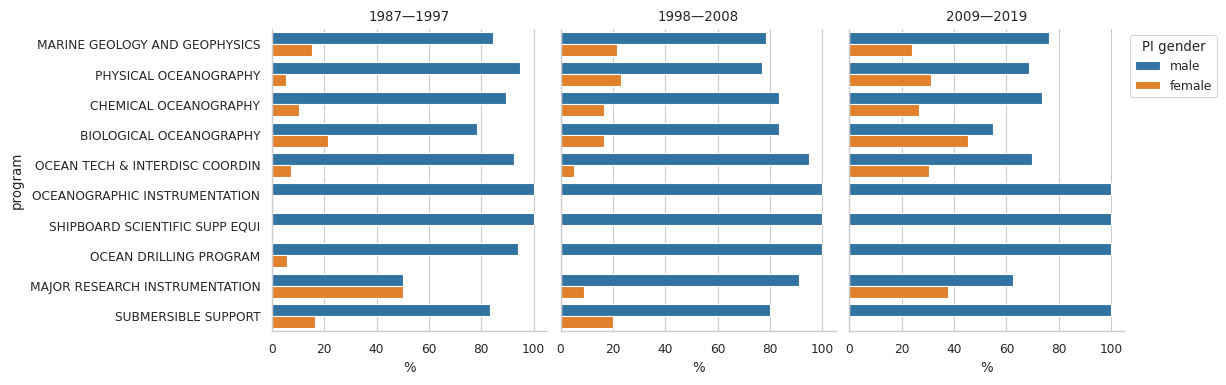

In [24]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_top10_1, awards_top10_2, awards_top10_3], titles):
    df_1 = df.groupby(['program','PI_gender'])['Abstract'].count()
    df_2 = df_1.groupby(['program']).sum()
    df_prog_pi = (df_1.div(df_2) * 100).reindex(top10_programs.index, level='program')
    dflist.append(df_prog_pi.unstack())
    df_prog_pi = df_prog_pi.rename('percentage').reset_index()
    _ = sns.barplot(data=df_prog_pi, y='program', x='percentage', hue='PI_gender',
                    hue_order=['male','female'], order=top10_programs.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='%')

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='PI gender',loc='upper left',bbox_to_anchor=(1, 1))
sns.despine(fig)

by_program_pi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
by_program_pi.style.format('{:.2f}')

co-PI gender fraction across top 10 programs. The table and figure show the co-PI gender composition in the top 10 NSF-OCE programs.

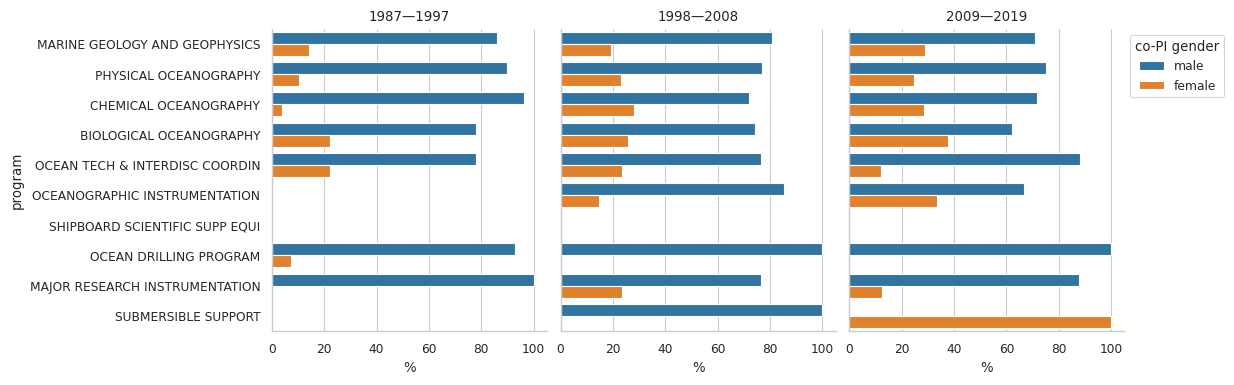

In [25]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_top10_1, awards_top10_2, awards_top10_3], titles):
    df_prog_copi = pd.DataFrame({'female': df.groupby(['program'])['co-PI_female_frac'].mean()})
    df_prog_copi['male'] = 1 - df_prog_copi.female
    df_prog_copi.columns.name = 'co-PI gender'
    df_prog_copi = df_prog_copi.reindex(top10_programs.index) * 100 # fraction -> percentage
    dflist.append(df_prog_copi)
    df = df_prog_copi.stack().reset_index().rename(columns={'level_0':'program', 0:'percentage'})
    _ = sns.barplot(data=df, y='program', x='percentage', hue='co-PI gender',
                    hue_order=['male','female'], order=top10_programs.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='%')

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='co-PI gender',loc='upper left',bbox_to_anchor=(1, 1))
sns.despine(fig)

by_program_copi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
by_program_copi.style.format('{:.2f}')

### Changes in gender composition across top 10 programs (in number of awards) at WHOI

The figure below shows the annual percentage of female PIs and co-PIs for each of the top 10 NSF-OCE programs (in number of awards) at WHOI. Solid lines represent the linear regression fit and points represent the individual years. The table shows the linear regressions results.

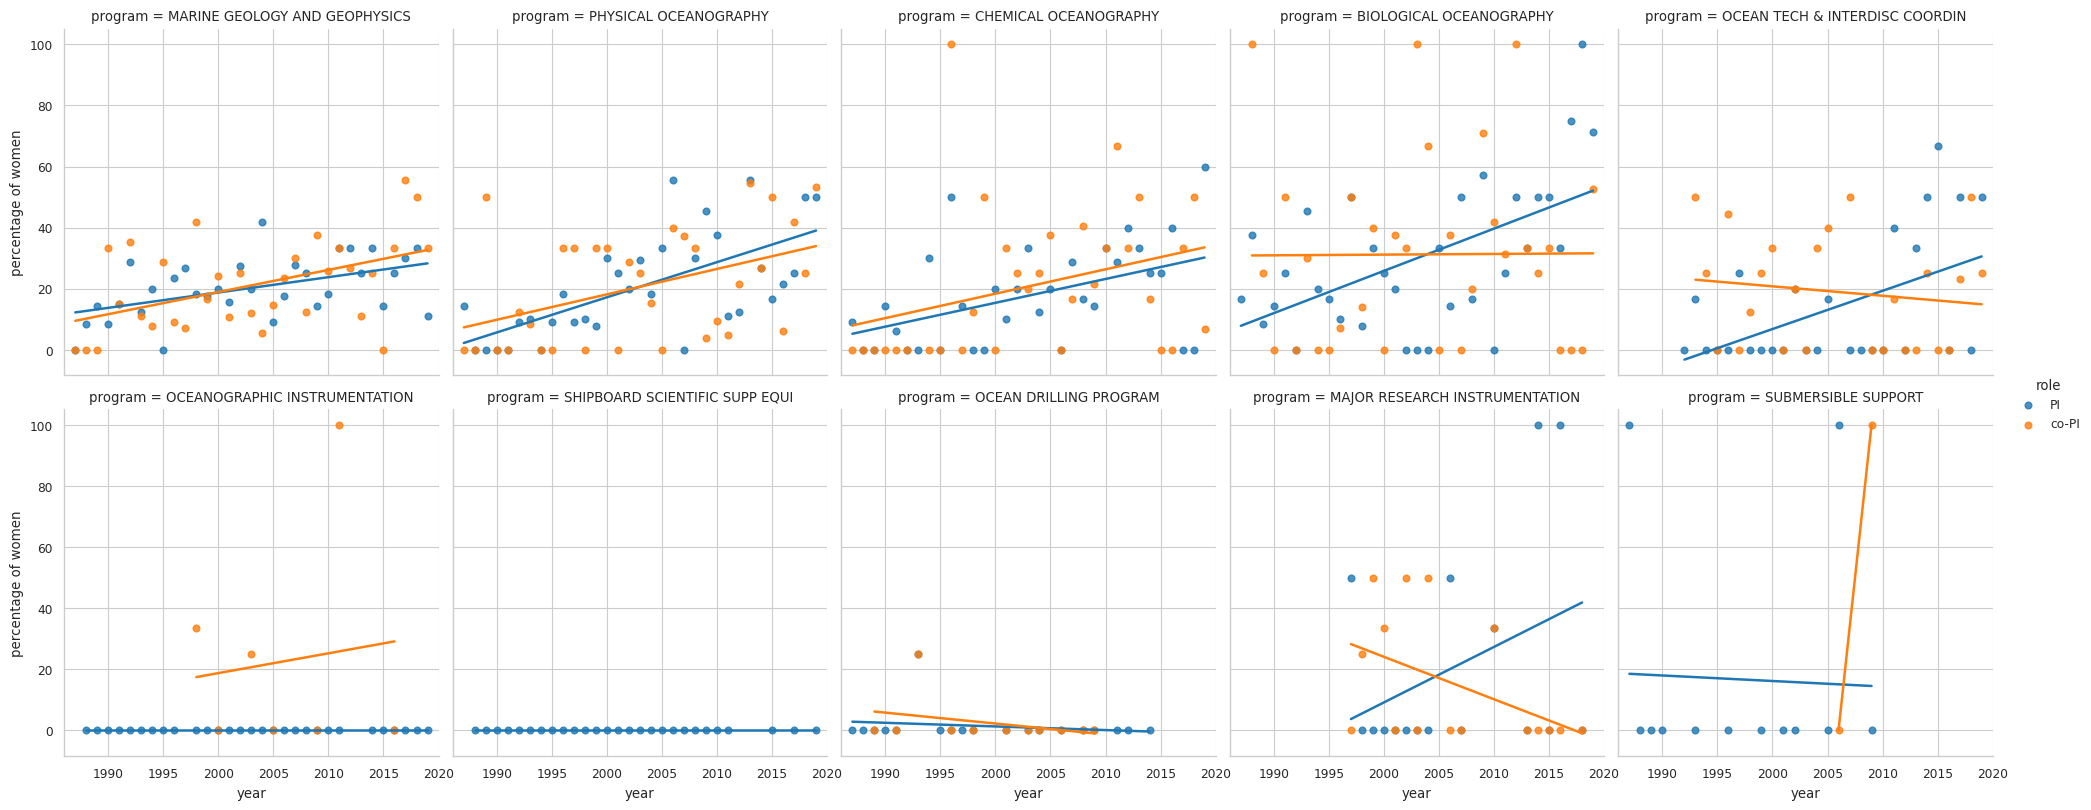

In [26]:
# female fraction of PIs
df = awards_top10.groupby(['program','year','PI_gender'])['Abstract'].count().unstack()
pi_female_pct_by_program = df.fillna(0).divide(df.sum(axis=1), axis=0)['female'] * 100
# female fraction of co-PIs
copi_female_pct_by_program = awards_top10.groupby(['program','year'])['co-PI_female_frac'].mean() * 100
# combined data
female_pct_by_program = pd.DataFrame({'PI':pi_female_pct_by_program, 'co-PI':copi_female_pct_by_program})
female_pct_by_program = female_pct_by_program.stack().reset_index().rename(columns={'level_2':'role',0:'percentage'})
# plot linear regression
g = sns.lmplot(x='year', y='percentage', data=female_pct_by_program, hue='role', ci=None, 
               col='program', col_wrap=5, col_order=top10_programs.index, height=4)
_ = g.set(xlim=(1986,2020))
for n in [0, 5]:
    _ = g.axes[n].set(ylabel='percentage of women')

female_pct = female_pct_by_program.set_index(['program','year','role']).unstack()
female_pct.columns = female_pct.columns.get_level_values(1)
params = []
for prog in top10_programs.index:
    lreg_pi, X = linreg(female_pct.loc[prog].index, female_pct.loc[prog,'PI'])
    if len(female_pct.loc[prog].dropna()) > 1:
        lreg_copi, X = linreg(female_pct.loc[prog].dropna().index, female_pct.loc[prog,'co-PI'].dropna())
        r2, slope, pval = lreg_copi.rsquared, lreg_copi.params[1], lreg_copi.pvalues[1]
    else:
        r2, slope, pval = np.nan, np.nan, np.nan
    params.append([lreg_pi.rsquared, lreg_pi.params[1], lreg_pi.pvalues[1],
                   r2, slope, pval])

lr_stats = pd.DataFrame(np.array(params), index=top10_programs.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female fraction/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the top 10 NSF-OCE programs at WHOI. The table shows the sum of the anomalies for each program which is a metric of how each program is performing relative to the academic workforce. Positive and negative values indicate that the program is overperforming and underperforming female representation in the academic workforce, respectively.

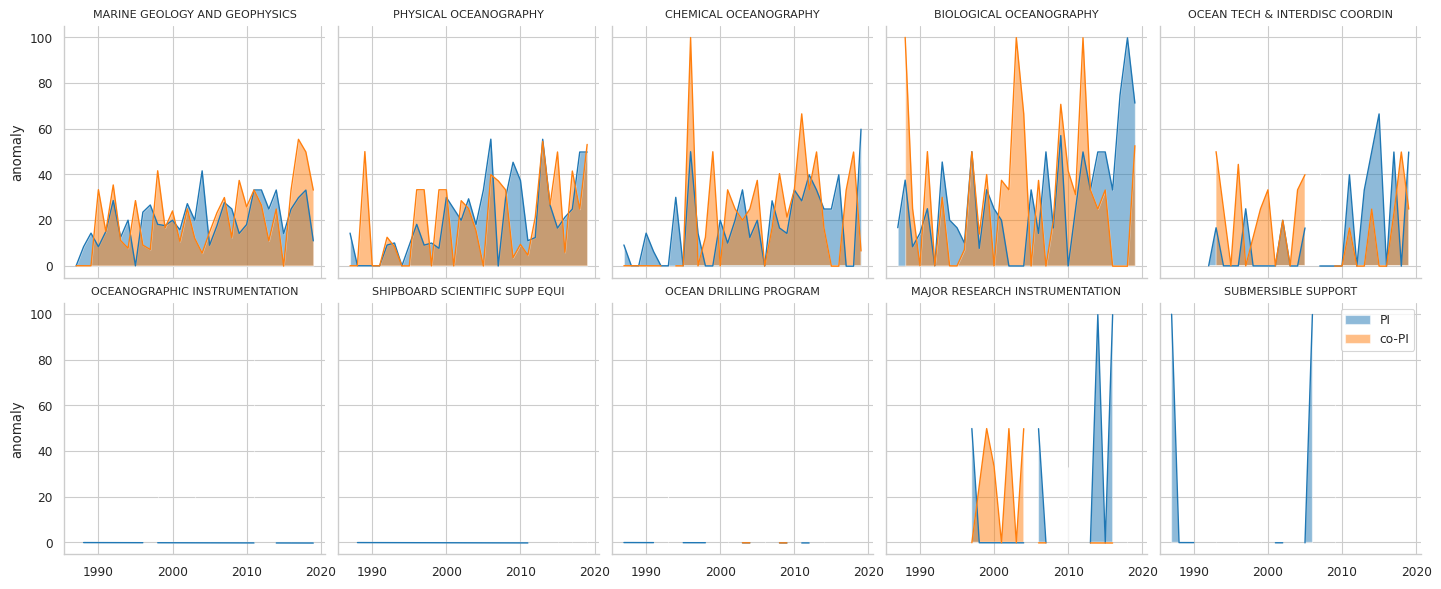

In [27]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(17.5, 7))
fig.subplots_adjust(hspace=0.1, wspace=0.05)
params = []
for ax, prog in zip(axs.ravel(), top10_programs.index):
    anom = female_pct.loc[prog] - df_ref
    _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
    _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
    _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
    _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)    
    _ = ax.set_title(prog, fontsize=8)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(2):
    _ = axs[i,0].set_ylabel('anomaly')

_ = ax.legend(loc='upper right')
sns.despine(fig)

df_anom = pd.DataFrame(data=params, index=top10_programs.index, columns=[['total sum','total sum'],['PI', 'co-PI']])
df_anom.style.format('{:.3f}')

## Research topics

Similarly to what was done in [Lima & Rheuban, 2018](https://tos.org/oceanography/article/topics-and-trends-in-nsf-ocean-sciences-awards), we applied non-negative matrix factorization (NMF) to the NSF-OCE abstracts to extract 22 research topics.

The table and histogram below show the number of awards and relative frequency of awards per research topic for the period 1987-2019.

,number of awards,percentage of total,cum percentage of total
topic,,,
sensor instrument measurement 12,198,12.38,12.38
circulation woce atlantic 13,162,10.12,22.50
climate change record 21,140,8.75,31.25
ridge mantle melt 4,111,6.94,38.19
hydrothermal vent fluid 11,109,6.81,45.00
wave internal turbulence 5,100,6.25,51.25
microbial phytoplankton cell 18,90,5.62,56.88
trace element isotope 14,82,5.12,62.00
sediment core organic 10,79,4.94,66.94


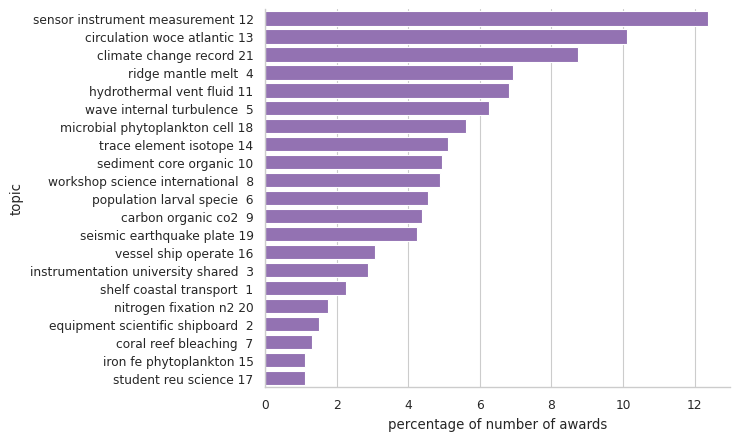

In [28]:
topic_map = {t+1:topic_names[t] for t in range(len(topic_names))}

res_topics = pd.DataFrame({'number of awards':whoi_awards.groupby('topic')['Abstract'].count().sort_values(ascending=False)})
res_topics.index = res_topics.index.map(topic_map)
res_topics['percentage of total'] = res_topics['number of awards'] / len(whoi_awards) * 100
res_topics['cum percentage of total'] = res_topics['percentage of total'].cumsum() 

fig, ax = plt.subplots(figsize=(6,5))
_ = sns.barplot(data=res_topics, y=res_topics.index, x='percentage of total', orient='h', color='C4', ax=ax)
_ = ax.set(xlabel='percentage of number of awards')
sns.despine(fig)

res_topics.style.format('{:.2f}', subset=['percentage of total','cum percentage of total'])

The table and histogram below show the total amount awarded per research topic for the period 1987-2019.

,amount awarded,percentage of total,cum percentage of total
topic,,,
vessel ship operate 16,"$418,824,484.26",3.146629,3.146629
sensor instrument measurement 12,"$387,347,400.91",2.910142,6.056771
workshop science international 8,"$249,451,036.11",1.874126,7.930897
circulation woce atlantic 13,"$233,135,455.93",1.751547,9.682444
climate change record 21,"$117,441,419.00",0.882338,10.564782
wave internal turbulence 5,"$86,947,131.24",0.653234,11.218016
instrumentation university shared 3,"$81,229,961.50",0.610281,11.828297
trace element isotope 14,"$79,328,499.78",0.595995,12.424292
microbial phytoplankton cell 18,"$69,229,190.93",0.520119,12.944411


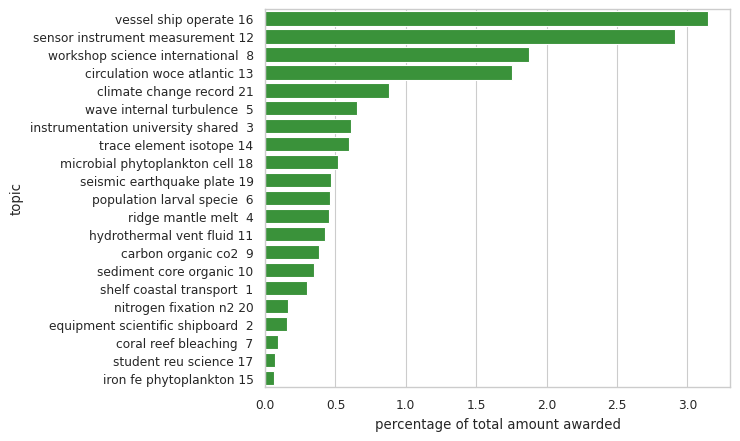

In [29]:
res_topics_amount = pd.DataFrame({'amount awarded':whoi_awards.groupby('topic')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
res_topics_amount.index = res_topics_amount.index.map(topic_map)
res_topics_amount['percentage of total'] = res_topics_amount['amount awarded'] / awards.tot_amount_adjusted.sum() * 100
res_topics_amount['cum percentage of total'] = res_topics_amount['percentage of total'].cumsum() 

fig, ax = plt.subplots(figsize=(6,5))
_ = sns.barplot(data=res_topics_amount, y=res_topics_amount.index, x='percentage of total', orient='h', color='C2', ax=ax)
_ = ax.set(xlabel='percentage of total amount awarded')

res_topics_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by research topic.

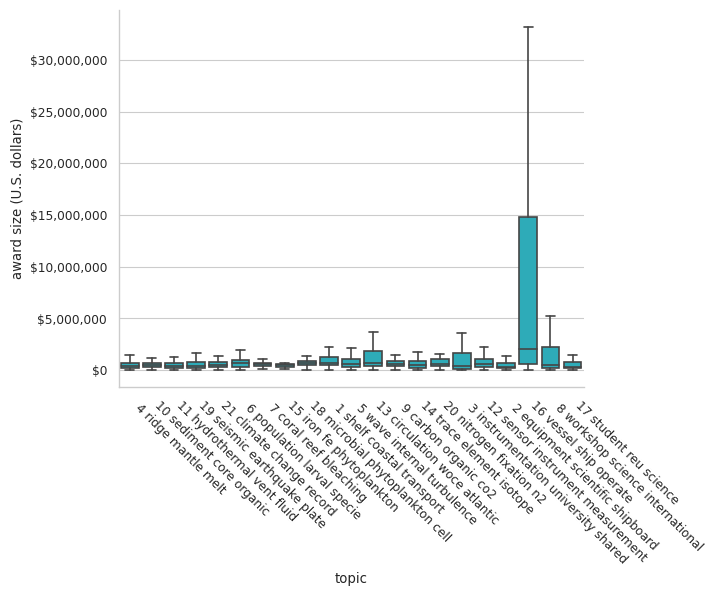

In [30]:
topic_order = np.array([4,10,11,19,21,6,7,15,18,1,5,13,9,14,20,3,12,2,16,8,17]) # order topics by program
fig, ax = plt.subplots(figsize=(6, 5))
_ = sns.boxplot(x='topic', y='tot_amount_adjusted', data=whoi_awards, showfliers=False,
                order=topic_order, color='C9', ax=ax )
_ = ax.set(xticklabels=topic_names_r[topic_order-1])
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
sns.despine(fig)

### Frequency distribution of topics by PI gender at WHOI

The table and figure below show the distribution (relative proportion) of different topics by PI gender. They show how the awards from each gender (PI) are distributed across the different topics.

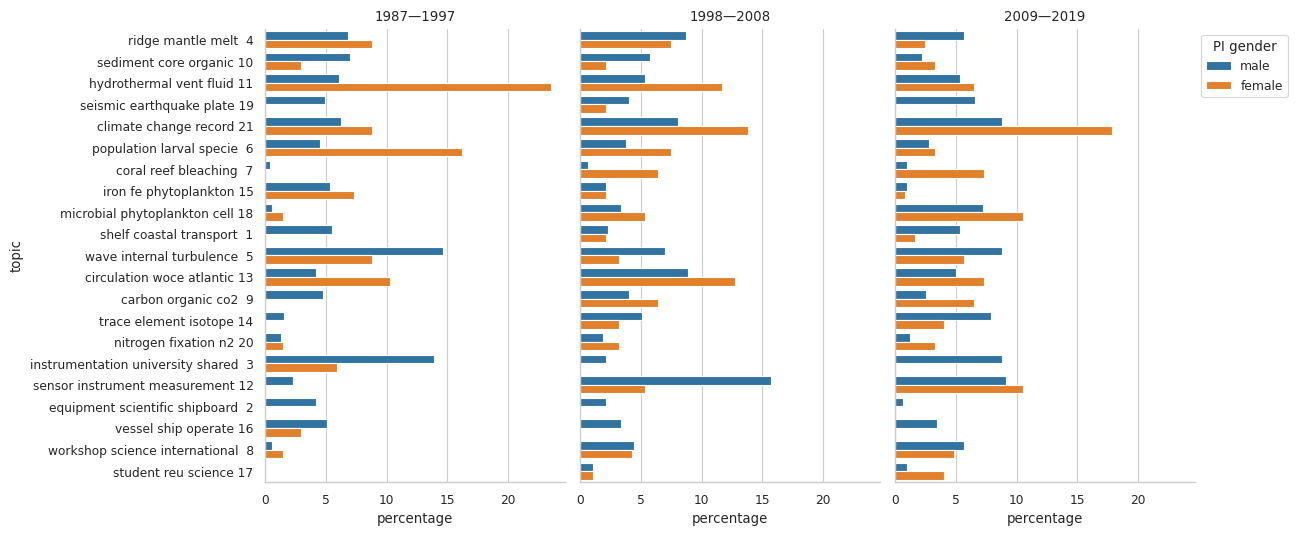

In [31]:
awards_1 = whoi_awards[whoi_awards.year<1998]                        # 1987-1997
awards_2 = whoi_awards[(whoi_awards.year>1997) & (whoi_awards.year<2009)] # 1998-2008
awards_3 = whoi_awards[whoi_awards.year>2008]                        # 2009-2019

dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_1, awards_2, awards_3], titles):
    df_1 = df.groupby(['topic','PI_gender'])['Abstract'].count()
    df_2 = df.groupby(['PI_gender'])['Abstract'].count()
    df_pct = (df_1.div(df_2) * 100)
    df_pct = df_pct.unstack()
    df_pct = df_pct.reindex(topic_order)
    df_pct.index = topic_names[topic_order-1]
    dflist.append(df_pct)
    df_pct = df_pct.stack().reset_index().rename(columns={'level_0':'topic', 0:'percentage'})
    _ = sns.barplot(data=df_pct, y='topic', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
ax.legend(title='PI gender',loc='upper left',bbox_to_anchor=(1, 1))
sns.despine(fig)

df_topics = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
df_topics.style.format('{:.2f}')

### Gender composition across research topics at WHOI

PI gender percentage across research topics. Gender composition of PIs in the different research topics.

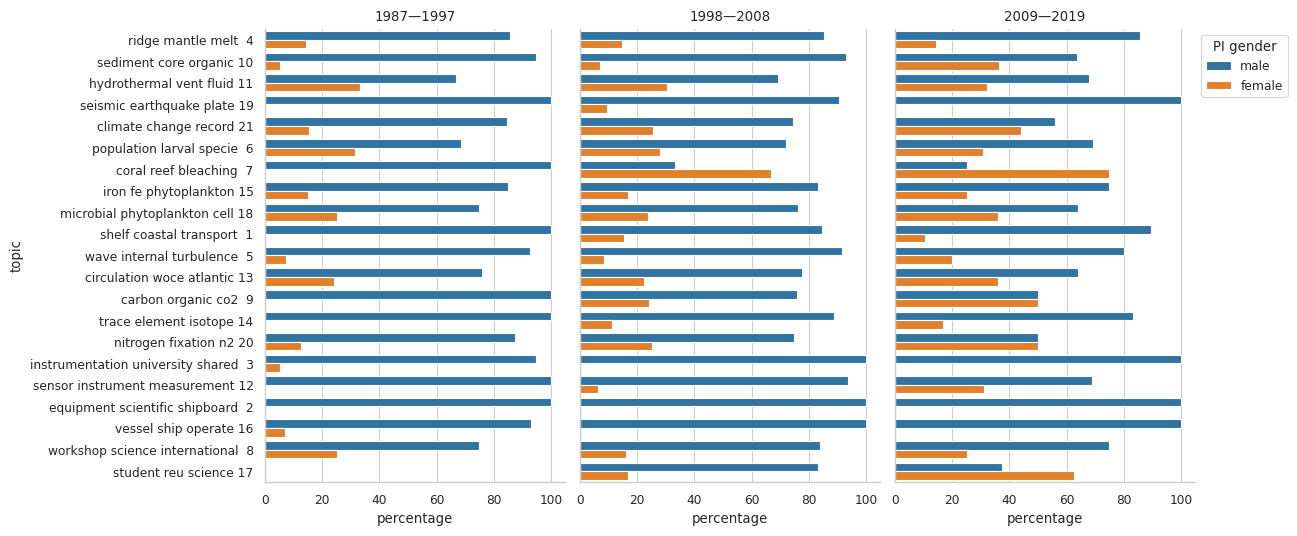

In [32]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_1, awards_2, awards_3], titles):
    df_pct = df.groupby(['topic','PI_gender'])['Abstract'].count().unstack()
    df_pct = df_pct.fillna(0).divide(df_pct.sum(axis=1), axis=0) * 100 # fraction -> percentage
    df_pct = df_pct.reindex(topic_order)
    df_pct.index = topic_names[topic_order-1]
    dflist.append(df_pct)
    df_pct = df_pct.stack().reset_index().rename(columns={'level_0':'topic', 0:'percentage'})
    _ = sns.barplot(data=df_pct, y='topic', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='PI gender',loc='upper left',bbox_to_anchor=(1, 1))
sns.despine(fig)

by_topic_pi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
by_topic_pi.style.format('{:.2f}')

co-PI gender percentage across research topics. Gender composition of co-PIs in the different research topics.

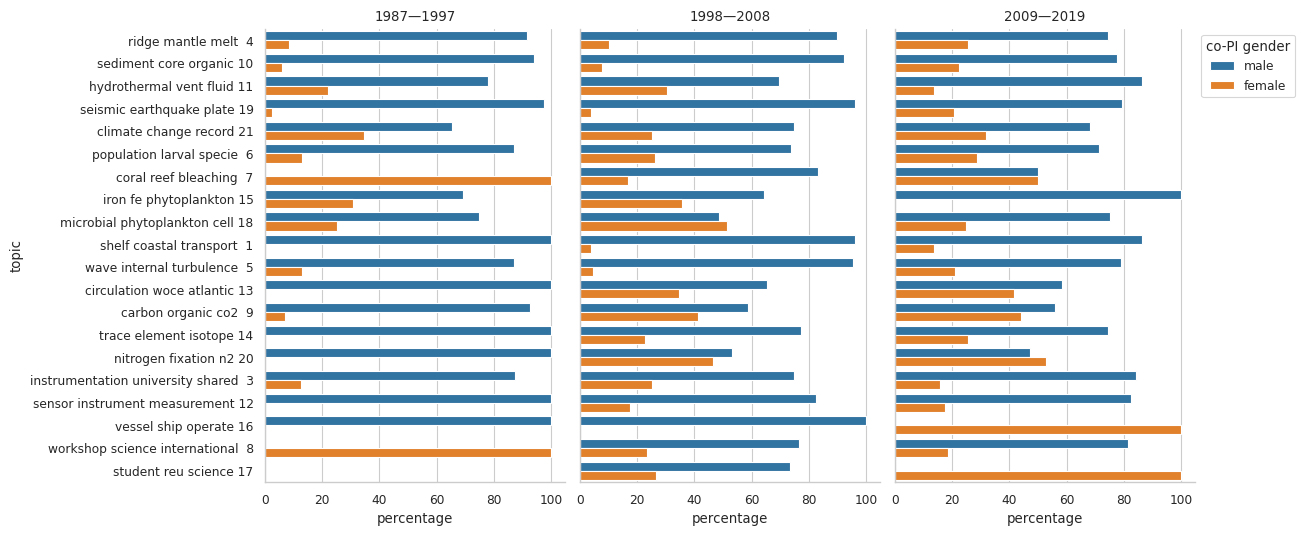

In [33]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12,6))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_1, awards_2, awards_3], titles):
    df_pct = pd.DataFrame({'female':df.groupby(['topic'])['co-PI_female_frac'].mean()})
    df_pct['male'] = 1 - df_pct.female
    df_pct = df_pct.reindex(topic_order) * 100 # fraction -> percentage
    df_pct.index = topic_names[topic_order-1]
    df_pct.columns.name = 'co-PI gender'
    dflist.append(df_pct)
    df_pct = df_pct.stack().reset_index().rename(columns={'level_0':'topic', 0:'percentage'})
    _ = sns.barplot(data=df_pct, y='topic', x='percentage', orient='h', hue='co-PI gender',
                    hue_order=['male','female'], ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)
    
for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='co-PI gender',loc='upper left',bbox_to_anchor=(1, 1))
sns.despine(fig)

by_topic_copi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
by_topic_copi.style.format('{:.2f}')

### Changes in gender composition across research topics at WHOI

The figure below shows time series of the annual percentage of female PIs and co-PIs for each of the identified research topics. Solid lines represent the linear regression fit and the points represent the individual years. The number of awards per year in each topic is small (<10), therefore the high variability from year to year.

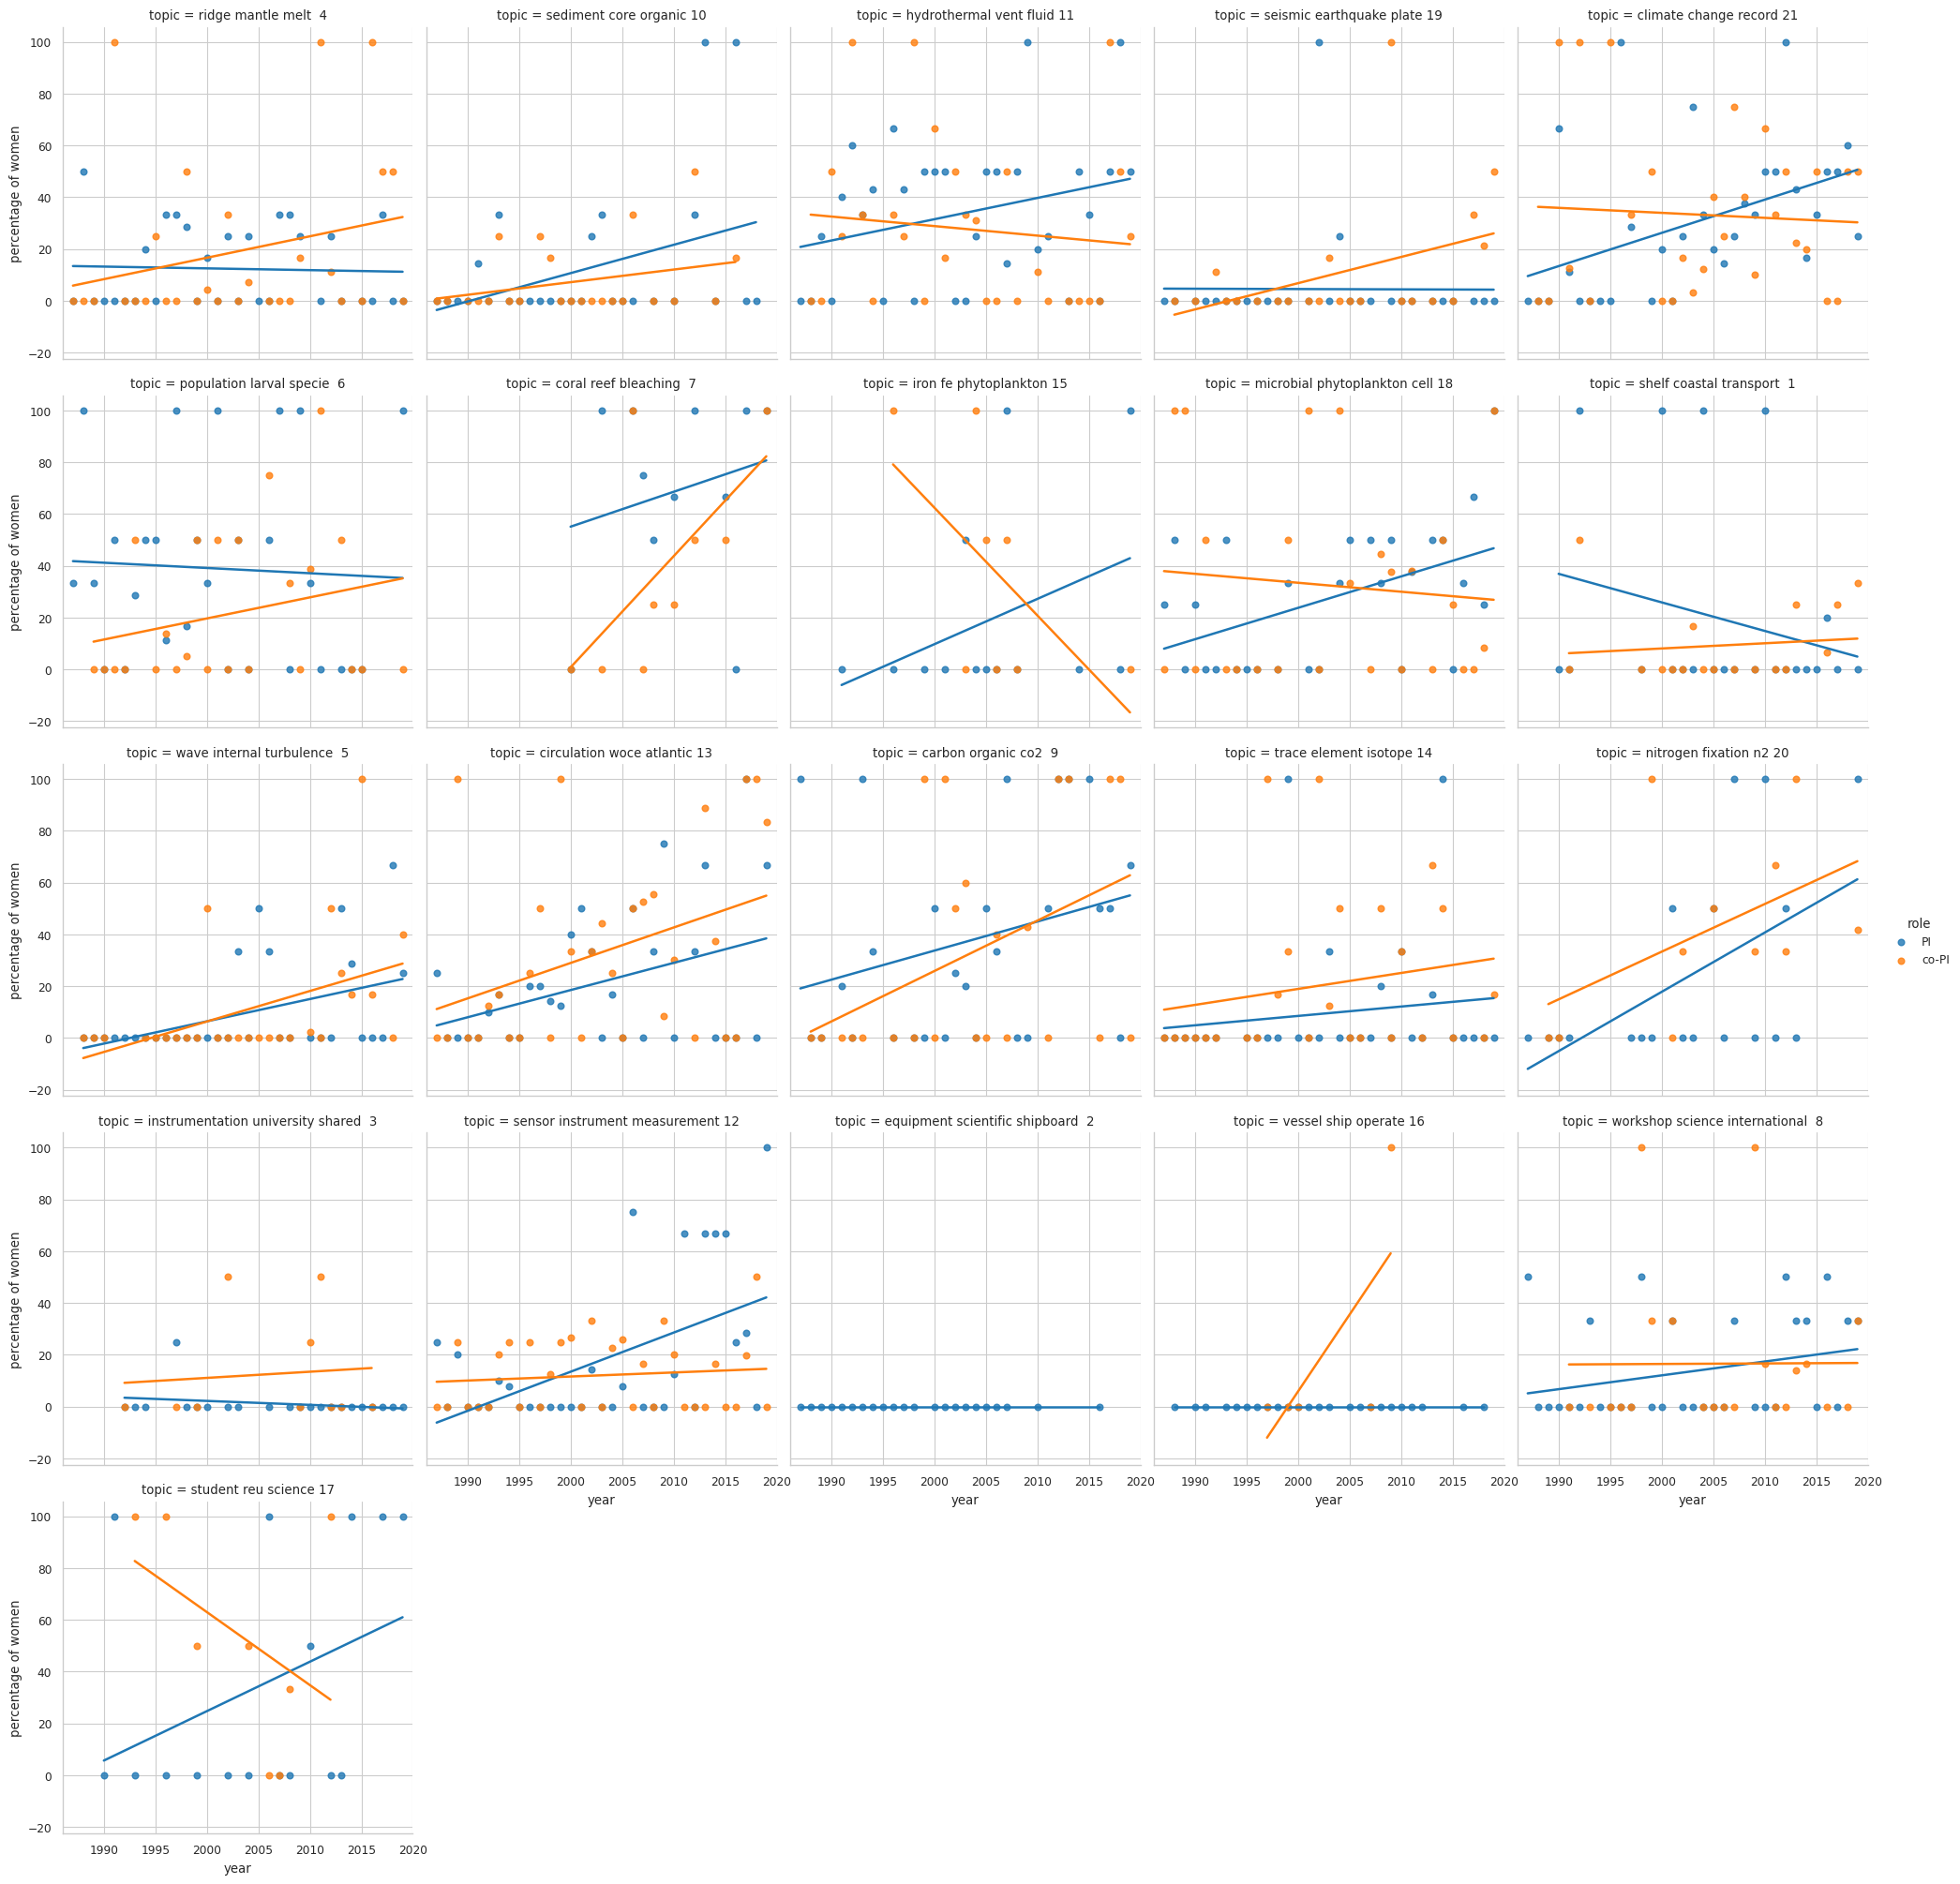

In [34]:
df = whoi_awards.groupby(['topic','year','PI_gender'])['Abstract'].count().unstack()
pi_gender_by_topic = df.fillna(0).divide(df.sum(axis=1), axis=0)['female']
copi_gender_by_topic = whoi_awards.groupby(['topic', 'year'])['co-PI_female_frac'].mean()
female_pct_by_topic = pd.DataFrame({'PI': pi_gender_by_topic * 100, 'co-PI': copi_gender_by_topic * 100})
female_pct_by_topic = female_pct_by_topic.stack().reset_index().rename(columns={'level_2':'role', 0:'percentage'})
female_pct_by_topic['topic'] = female_pct_by_topic.topic.map(topic_map)
female_pct_by_topic

g = sns.lmplot(x='year', y='percentage', data=female_pct_by_topic, hue='role', ci=None,
               col='topic', col_wrap=5, col_order=topic_names[topic_order-1], height=4)
_ = g.set(xlim=(1986,2020))
for n in [0, 5, 10, 15, 20]:
    _ = g.axes[n].set(ylabel='percentage of women')

The table below shows the linear regressions results.

In [35]:
female_pct = female_pct_by_topic.set_index(['topic','year','role']).unstack()
female_pct.columns = female_pct.columns.get_level_values(1)
params = []
for t in topic_names[topic_order-1]:
    lreg_pi, X = linreg(female_pct.loc[t].index, female_pct.loc[t,'PI'])
    if len(female_pct.loc[t].dropna()) > 1:
        lreg_copi, X = linreg(female_pct.loc[t].dropna().index, female_pct.loc[t,'co-PI'].dropna())
        r2, slope, pval = lreg_copi.rsquared, lreg_copi.params[1], lreg_copi.pvalues[1]
    else:
        r2, slope, pval = np.nan, np.nan, np.nan    
    params.append([lreg_pi.rsquared, lreg_pi.params[1], lreg_pi.pvalues[1],
                   r2, slope, pval])

lr_stats = pd.DataFrame(np.array(params), index=topic_names[topic_order-1],
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female fraction/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the identified research topic. The table shows the sum of the anomalies for each topic which is a metric of how each topic is performing relative to the academic workforce. Positive and negative values indicate that the topic is overperforming and underperforming female representation in the academic workforce, respectively.

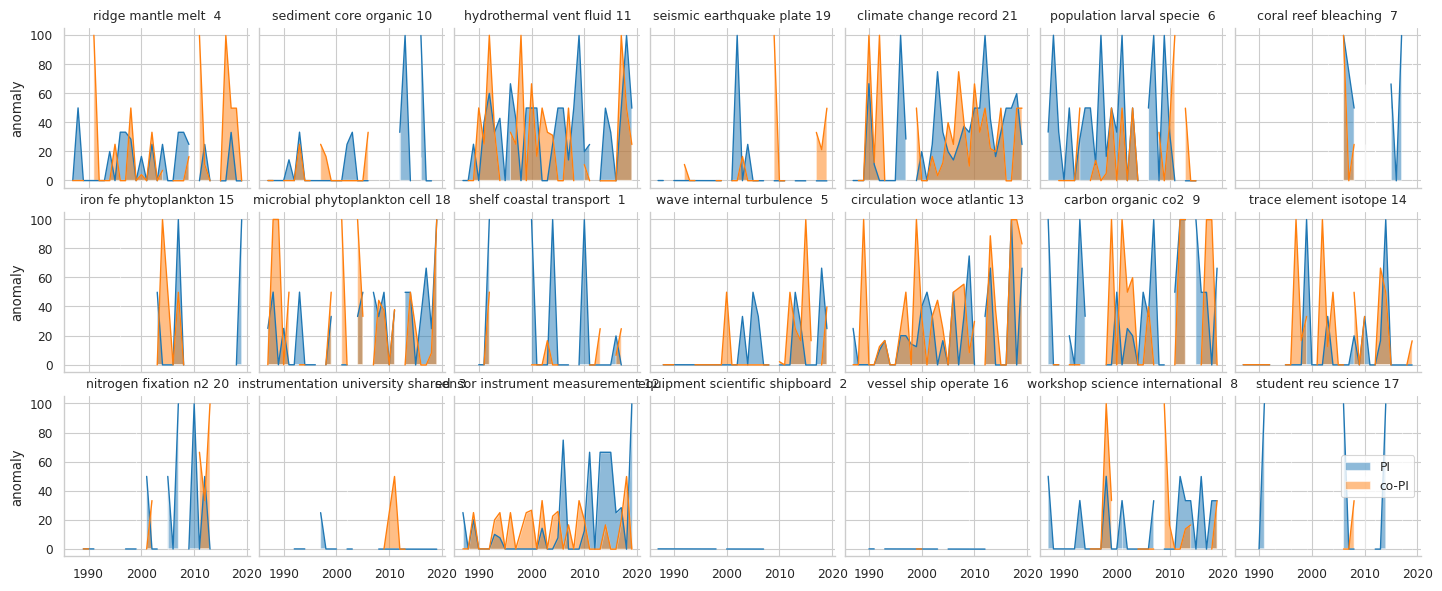

In [36]:
fig, axs = plt.subplots(3, 7, sharex=True, sharey=True, figsize=(17.5, 7))
fig.subplots_adjust(hspace=0.15, wspace=0.05)
params = []
for ax, t in zip(axs.ravel(), topic_names[topic_order-1]):
    anom = female_pct.loc[t] - df_ref
    _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
    _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
    _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
    _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)
    _ = ax.set_title(t, fontsize=9)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(3):
    _ = axs[i,0].set_ylabel('anomaly')

_ = ax.legend(loc='best')
sns.despine(fig)

df_anom = pd.DataFrame(data=params, index=topic_names_r, columns=[['total sum','total sum'],['PI', 'co-PI']])
df_anom.style.format('{:.3f}')

## Award types

### Number of awards 

,number of awards,percentage of total,cum percentage of total
standard,1260,78.75,78.75
Collaborative Research,259,16.19,94.94
EAGER,42,2.62,97.56
RAPID,17,1.06,98.62
REU,12,0.75,99.38
CAREER,5,0.31,99.69
RUI,1,0.06,99.75


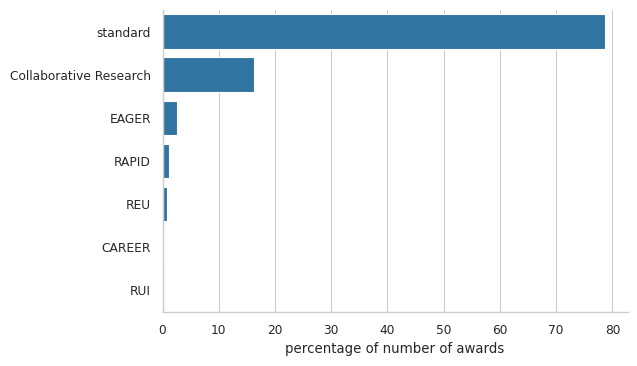

In [37]:
awards_clean = whoi_awards[whoi_awards.award_type!='CMG']
awards_clean = awards_clean[awards_clean.award_type!='POWRE']

atypes = pd.DataFrame({'number of awards': awards_clean.award_type.value_counts()})
atypes['percentage of total'] =  atypes['number of awards'] / len(whoi_awards) * 100
atypes['cum percentage of total'] = atypes['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = sns.barplot(data=atypes, y=atypes.index, x='percentage of total', orient='h', color='C0', ax=ax)
_ = ax.set(xlabel='percentage of number of awards')
sns.despine(fig)

atypes.style.format('{:.2f}', subset=['percentage of total','cum percentage of total'])

### Amount awarded 

,amount awarded,percentage of total,cum percentage of total
award_type,,,
standard,"$1,828,866,186.57",84.150669,84.150669
Collaborative Research,"$320,824,301.72",14.761922,98.912591
REU,"$8,677,883.79",0.399291,99.311882
EAGER,"$4,525,663.93",0.208237,99.520119
CAREER,"$4,421,981.64",0.203466,99.723585
RAPID,"$1,990,962.01",0.091609,99.815194
RUI,"$739,059.74",0.034006,99.849200


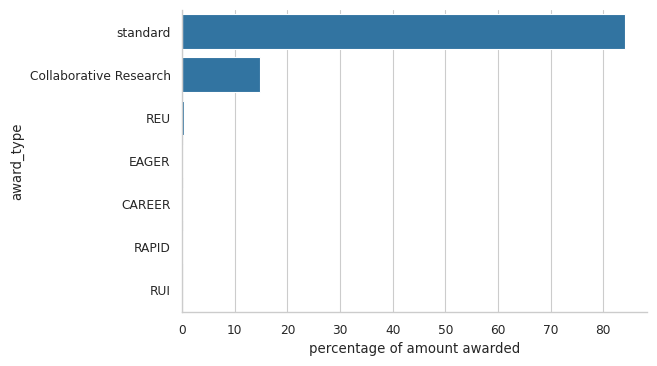

In [38]:
atype_amount = pd.DataFrame(
    {'amount awarded':
     awards_clean.groupby('award_type')['tot_amount_adjusted'].sum().sort_values(ascending=False)})
atype_amount['percentage of total'] = (atype_amount['amount awarded'] / whoi_awards['tot_amount_adjusted'].sum()
                                       * 100)
atype_amount['cum percentage of total'] = atype_amount['percentage of total'].cumsum()

fig, ax = plt.subplots()
_ = sns.barplot(data=atype_amount, y=atype_amount.index, x='percentage of total', orient='h', color='C0', ax=ax)
_ = ax.set(xlabel='percentage of amount awarded')
sns.despine(fig)

atype_amount.style.format('${0:,.2f}', subset='amount awarded')

Boxplot of award size by award type.

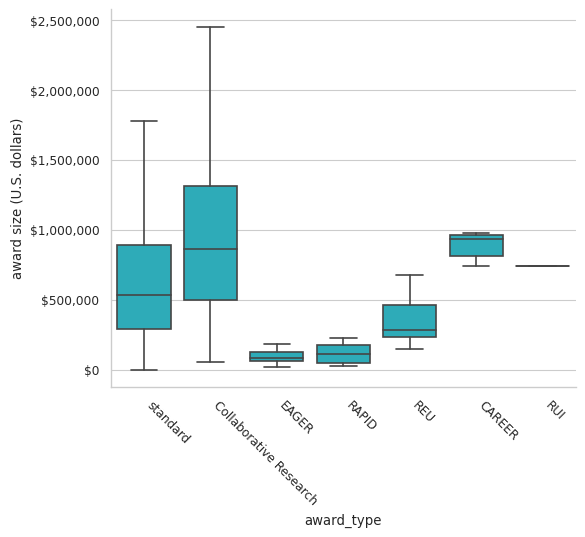

In [39]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.boxplot(data=awards_clean, x='award_type', y='tot_amount_adjusted', showfliers=False,
                order=atypes.index, color='C9', ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
sns.despine(fig)

Boxplot of award size by award type and PI gender.

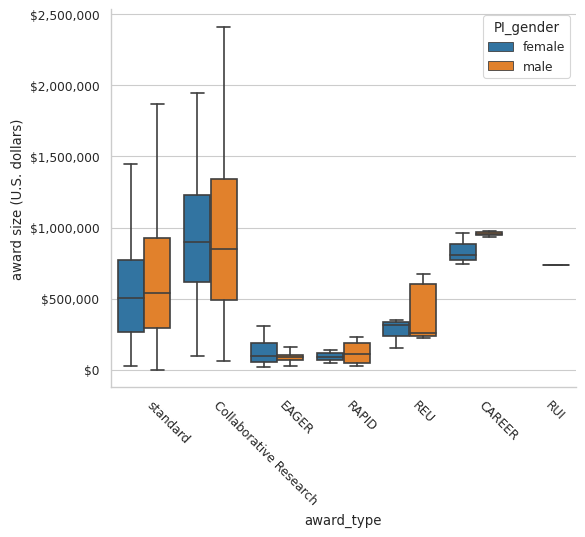

In [40]:
fig, ax = plt.subplots(figsize=(6,5))
_ = sns.boxplot(data=awards_clean, x='award_type', y='tot_amount_adjusted', showfliers=False,
                order=atypes.index, hue='PI_gender', ax=ax)
_ = ax.yaxis.set_major_formatter(fmt)
_ = ax.set_ylabel('award size (U.S. dollars)')
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=-45, ha='left')
sns.despine(fig)

The number and percentage of each award type in each year between 1987 2019. The annual amount awarded and percentage of annual amount awarded for each award type between 1987 2019.

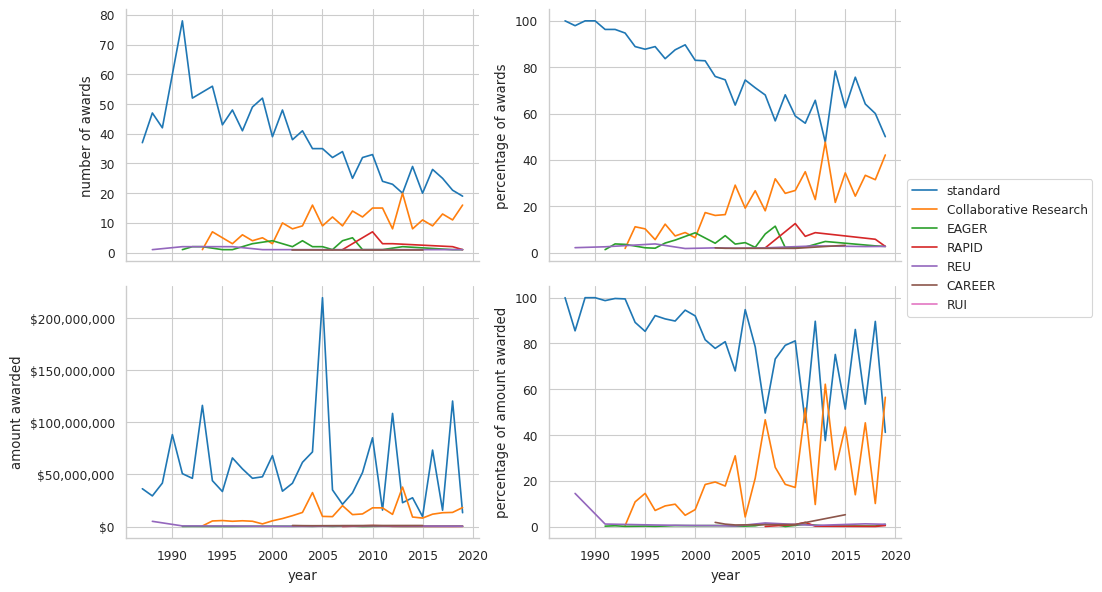

In [41]:
atype_year = pd.DataFrame({'number of awards': awards_clean.groupby(['year','award_type'])['Abstract'].count()})
atype_year['percentage of awards'] = atype_year['number of awards'].div(num_awards_per_year) * 100
atype_year['amount awarded'] = awards_clean.groupby(['year','award_type'])['tot_amount_adjusted'].sum()
atype_year['percentage of amount awarded'] = atype_year['amount awarded'].div(amount_awarded_per_year) * 100
atype_year = atype_year.reset_index()

fig, axs = plt.subplots(2, 2, sharex=True, figsize=(10,7))
fig.subplots_adjust(hspace=0.1)
_ = sns.lineplot(data=atype_year, x='year', y='number of awards', hue='award_type', hue_order=atypes.index, ax=axs[0,0], legend=False)
_ = sns.lineplot(data=atype_year, x='year', y='percentage of awards', hue='award_type', hue_order=atypes.index, ax=axs[0,1])
_ = sns.lineplot(data=atype_year, x='year', y='amount awarded', hue='award_type', hue_order=atypes.index, ax=axs[1,0], legend=False)
_ = sns.lineplot(data=atype_year, x='year', y='percentage of amount awarded', hue='award_type', hue_order=atypes.index, ax=axs[1,1], legend=False)
_ = axs[1,0].yaxis.set_major_formatter(fmt)
_ = axs[0,1].legend(loc='upper left',bbox_to_anchor=(1, 0.35))
sns.despine(fig)

### Frequency distribution of award types by PI gender

The table and figure below show the distribution (relative proportion) of different award types by PI gender. They show how the awards from each gender (PI) are distributed across the different award types.

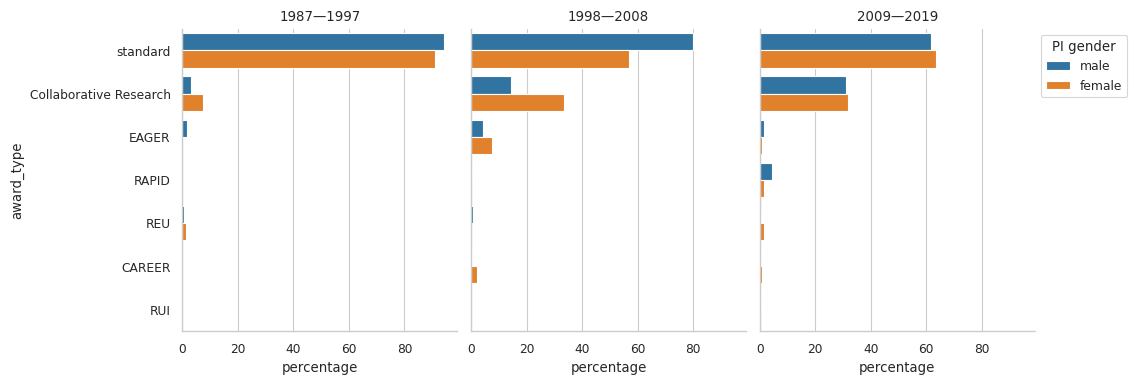

In [42]:
awards_clean_1 = awards_clean[awards_clean.year<1998]                              # 1987-1997
awards_clean_2 = awards_clean[(awards_clean.year>1997) & (awards_clean.year<2009)] # 1998-2008
awards_clean_3 = awards_clean[awards_clean.year>2008]                              # 2009-2019

dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_clean_1, awards_clean_2, awards_clean_3], titles):
    df1 = df.groupby(['award_type','PI_gender'])['Abstract'].count()
    df2 = df.groupby(['PI_gender'])['Abstract'].count()
    df_pct = (df1.div(df2, axis=0) * 100).reindex(atypes.index, level='award_type')
    dflist.append(df_pct.unstack().fillna(0))
    df_pct = df_pct.rename('percentage').reset_index()
    _ = sns.barplot(data=df_pct, y='award_type', x='percentage', orient='h', hue='PI_gender',
                    hue_order=['male','female'], order=atypes.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t)

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
_ = ax.legend(title='PI gender',loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(fig)

df_atype = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
df_atype.style.format('{:.2f}')

### Gender composition across award types

PI gender percentage across award types.

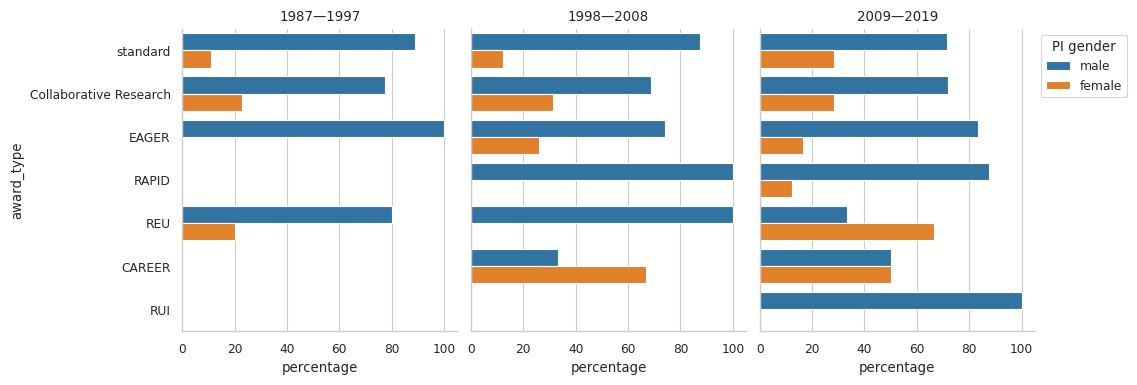

In [43]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_clean_1, awards_clean_2, awards_clean_3], titles):
    df1 = df.groupby(['award_type','PI_gender'])['Abstract'].count()
    df2 = df1.unstack().sum(axis=1)
    df_pct = df1.divide(df2, axis=0) * 100 # fraction -> percentage
    df_pct = df_pct.reindex(atypes.index, level=0)
    dflist.append(df_pct.unstack().fillna(0))
    df_pct = df_pct.rename('percentage').reset_index()
    _ = sns.barplot(data=df_pct, y='award_type', x='percentage', hue='PI_gender',
                    hue_order=['male','female'], order=atypes.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='percentage')    

for n in range(1,3):
    _ = axs[n].set_ylabel('')
    
_ = ax.legend(title='PI gender',loc='upper left', bbox_to_anchor=(1, 1))
sns.despine(fig)

by_atype_pi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
by_atype_pi.style.format('{:.2f}')

co-PI gender percentage across award types.

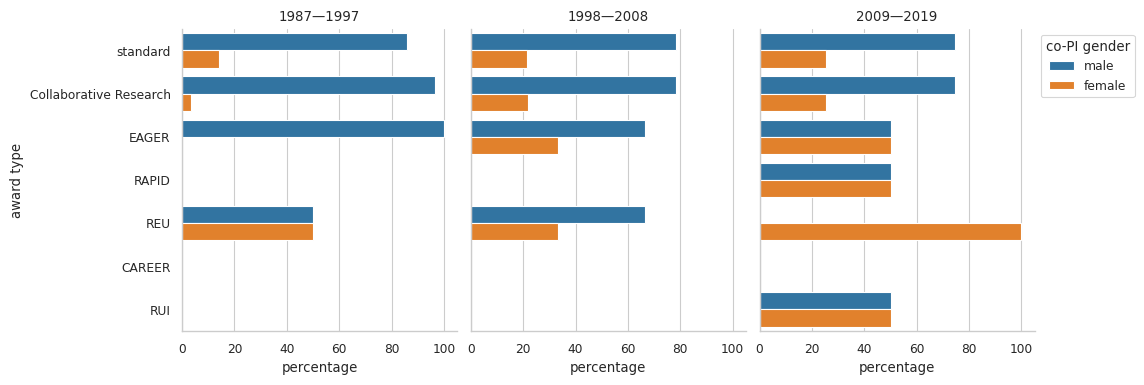

In [44]:
dflist = []
fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(11,4))
fig.subplots_adjust(wspace=0.05)
for ax, df, t in zip(axs.ravel(), [awards_clean_1, awards_clean_2, awards_clean_3], titles):
    df_pct = pd.DataFrame({'female': df.groupby(['award_type'])['co-PI_female_pct'].mean()})
    df_pct['male'] = 100 - df_pct.female
    df_pct.columns.name = 'co-PI gender'
    df_pct = df_pct.reindex(atypes.index)
    dflist.append(df_pct)
    df_pct = df_pct.stack().reset_index().rename(columns={'level_0':'award type', 0:'percentage'})
    _ = sns.barplot(data=df_pct, y='award type', x='percentage', hue='co-PI gender',
                    hue_order=['male','female'], order=atypes.index, ax=ax)
    _ = ax.legend_.remove()
    _ = ax.set(title=t, xlabel='percentage')

for n in range(1,3):
    _ = axs[n].set_ylabel('')

ax.legend(title='co-PI gender',loc='upper left',bbox_to_anchor=(1, 1))
sns.despine(fig)

by_atype_copi = pd.concat(dflist, keys=['1987-1997','1998-2008', '2009-2019'], axis=1).fillna(0)
by_atype_copi.style.format('{:.2f}')

### Changes in gender composition across award types

The figure below shows time series of the annual percentage of female PIs and co-PIs for each NSF-OCE award types. Solid lines represent the linear regression fit and points represent the individual years. The table shows the linear regressions results.

Except for Collaborative Research and standard awards, the number of awards per year in each award type is small, therefore the variability is high. Many award types don't have enough points to fit a linear regression.

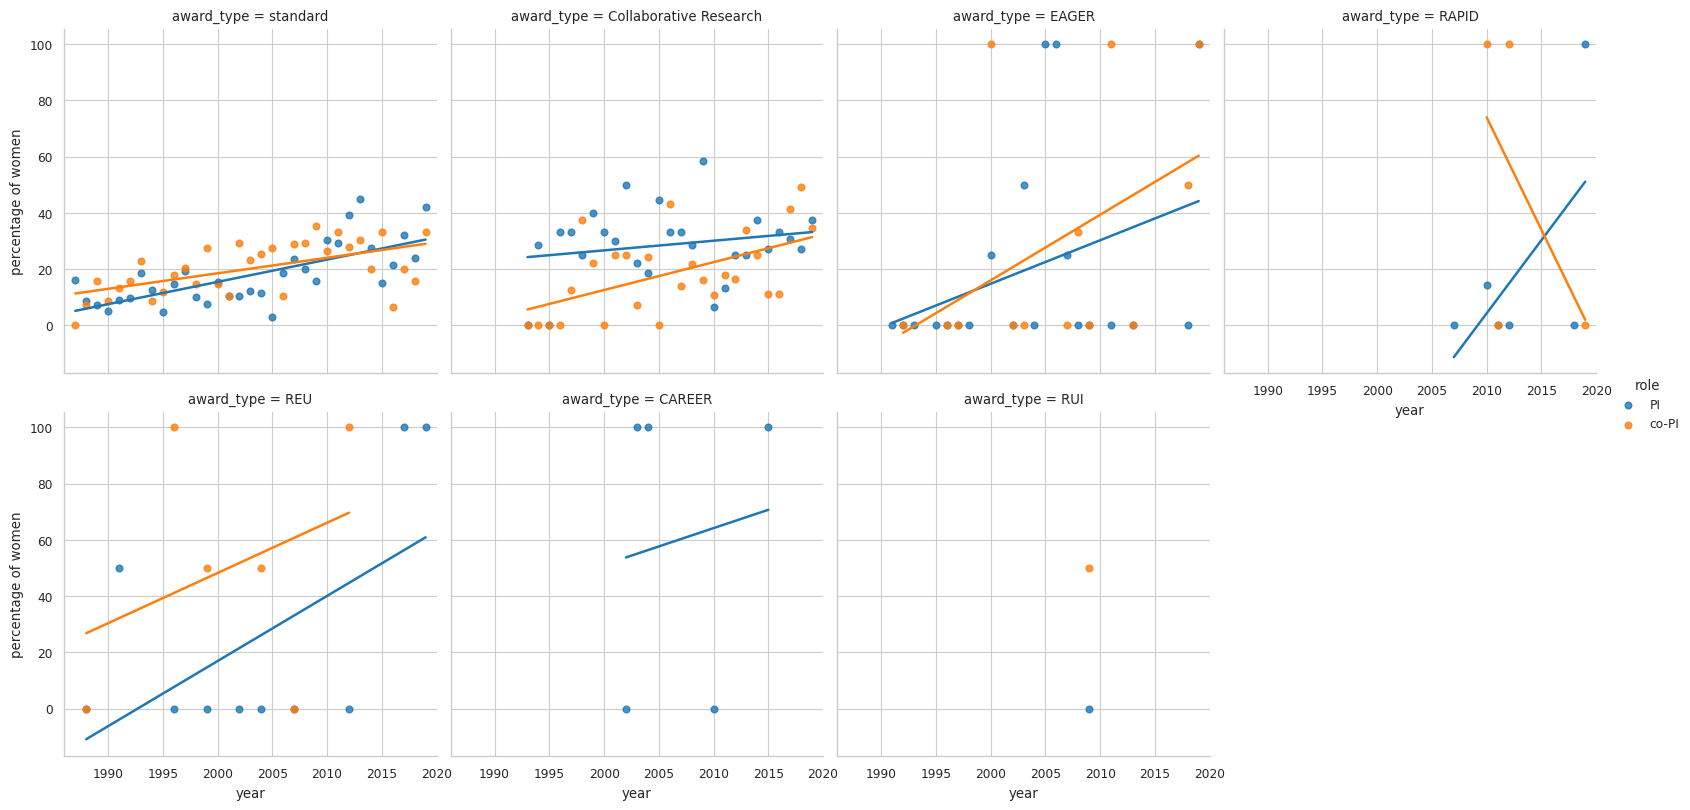

In [45]:
# female fraction of PIs
df = awards_clean.groupby(['award_type','year','PI_gender'])['Abstract'].count().unstack()
pi_female_pct_by_atype = df.fillna(0).divide(df.sum(axis=1), axis=0)['female'] * 100
# female fraction of co-PIs
copi_female_pct_by_atype = awards_clean.groupby(['award_type','year'])['co-PI_female_frac'].mean() * 100
# combined data
female_pct_by_atype = pd.DataFrame({'PI':pi_female_pct_by_atype, 'co-PI':copi_female_pct_by_atype})
female_pct_by_atype = female_pct_by_atype.stack().reset_index().rename(columns={'level_2':'role',0:'percentage'})
# plot linear regression
g = sns.lmplot(x='year', y='percentage', data=female_pct_by_atype, hue='role', ci=None,
               col='award_type', col_wrap=4, col_order=atypes.index, height=4)
_ = g.set(xlim=(1986,2020))
for n in [0, 4]:
    _ = g.axes[n].set(ylabel='percentage of women')

The table below shows the linear regressions results.

In [46]:
female_pct = female_pct_by_atype.set_index(['award_type','year','role']).unstack()
female_pct.columns = female_pct.columns.get_level_values(1)
params = []
for a in atypes.index:
    if len(female_pct.loc[a].dropna()) > 1:
        lreg_pi, X = linreg(female_pct.loc[a].index, female_pct.loc[a,'PI'])
        lreg_copi, X = linreg(female_pct.loc[a].dropna().index, female_pct.loc[a,'co-PI'].dropna())
        r2_pi, slope_pi, pval_pi = lreg_pi.rsquared, lreg_pi.params[1], lreg_pi.pvalues[1]
        r2_copi, slope_copi, pval_copi = lreg_copi.rsquared, lreg_copi.params[1], lreg_copi.pvalues[1]
    else:
        r2_copi, slope_copi, pval_copi = np.nan, np.nan, np.nan
        r2_pi, slope_pi, pval_pi = np.nan, np.nan, np.nan

    params.append([r2_pi, slope_pi, pval_pi, r2_copi, slope_copi, pval_copi])

lr_stats = pd.DataFrame(np.array(params), index=atypes.index,
                        columns=[['PI','PI','PI','co-PI','co-PI','co-PI'],
                                 ['R^2','slope','p-value','R^2','slope','p-value']])
lr_stats.style.format('{:.3f}', subset=['PI','co-PI'])

### Differences in gender composition with respect to academic workforce

Using the linear trend for the combined data (PI and co_PI) as reference we compute anomalies that represent how female fraction/representation differs from that in the ocean sciences academic workforce. The figure below shows a stem plot of the anomalies for the different award type. The table shows the sum of the anomalies for each award type which is a metric of how each award type is performing relative to the academic workforce. Positive and negative values indicate that the award type is overperforming and underperforming female representation in the academic workforce, respectively.

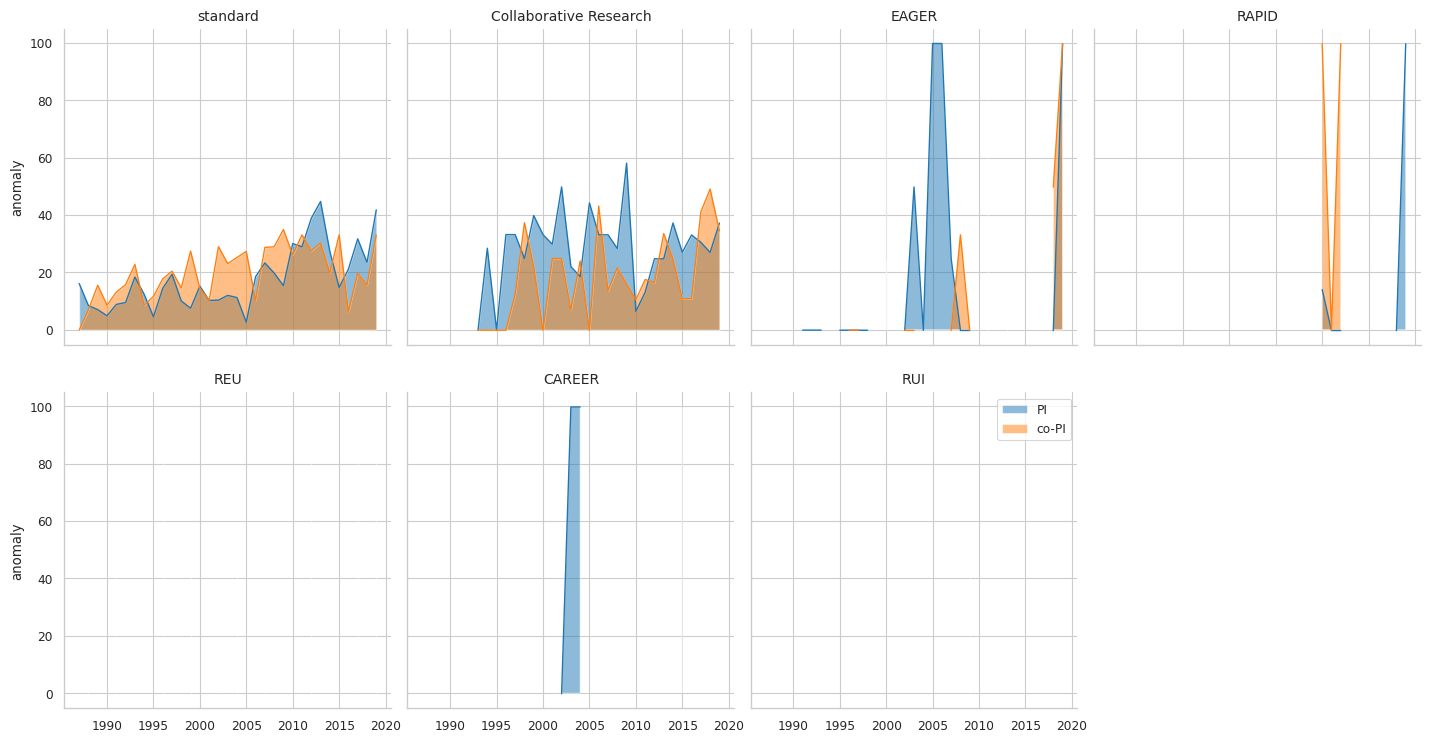

In [47]:
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(17.5, 9))
fig.subplots_adjust(hspace=0.15, wspace=0.05)
fig.delaxes(axs[1,3])
params = []
for ax, atype in zip(axs.ravel(), atypes.index):
    anom = female_pct.loc[atype] - df_ref
    _ = ax.fill_between(anom.index.values, anom.PI, alpha=0.5, label='PI')
    _ = ax.fill_between(anom.index.values, anom['co-PI'], alpha=0.5, label='co-PI')
    _ = ax.plot(anom.index.values, anom.PI, linewidth=1)
    _ = ax.plot(anom.index.values, anom['co-PI'], linewidth=1)           
    _ = ax.set_title(atype, fontsize=10)
    params.append([anom.sum()[0], anom.sum()[1]])

for i in range(2):
    _ = axs[i,0].set_ylabel('anomaly')

_ = ax.legend(loc='best')
sns.despine(fig)

df_anom = pd.DataFrame(data=params, index=atypes.index, columns=[['total sum','total sum'],['PI', 'co-PI']])
df_anom.style.format('{:.3f}')